# *Google Drive Setup*

## Install Modules

In [12]:
# install all needed packages

# mount data from drive
'''
!pip install tesseract
!pip install torchmetrics
!pip install torcheval
'''

'\n!pip install tesseract\n!pip install torchmetrics\n!pip install torcheval\n'

## Mount Data

In [13]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/NLP Datasets/FRconquest_split'

ModuleNotFoundError: No module named 'google.colab'

# Helper Functions

## File I/O

In [ ]:
import requests

api_file = "./API Keys/hugging_key.txt"
cohere_api_file = "./API Keys/cohere_key.txt"

def get_api_key(api_file):
    try:
        with open(api_file, 'r') as file:
            api_key = file.readline().strip()
            #print("Api Key acquired:")
            return api_key
    except FileNotFoundError:
        print(f"File '{api_file}' not found.")
    except IOError:
        print(f"Error reading file '{api_file}'.")
        
huggingface_key = get_api_key(api_file)
cohere_key = get_api_key(cohere_api_file)



## Data Structure Generation

In [ ]:

def get_doc_index(doc_names, doc_name):
    '''
    Returns doc index given corpus of doc names, and given document name
    '''
    return doc_names.index(doc_name)


## Tools

In [66]:
def second_small_index(arr):
    if len(arr) < 2:
        return None

    smallest = min(arr)
    second_smallest = float('inf')
    smallest_index = None
    second_smallest_index = None

    for i, num in enumerate(arr):
        if num < second_smallest and num > smallest:
            second_smallest = num
            second_smallest_index = i

    return second_smallest_index

In [67]:
def second_big_index(arr):
    if len(arr) < 2:
        return None

    largest = max(arr)
    second_largest = float('-inf')
    largest_index = None
    second_largest_index = None

    for i, num in enumerate(arr):
        if num > second_largest and num < largest:
            second_largest = num
            second_largest_index = i

    return second_largest_index

In [68]:
from dateutil import parser

def utils_parsetime(date_string):
    '''
    # old code doesn't work if date string is ambiguous
    x = re.match(r'.*([1-3][0-9]{3})', txt) #<--check if there is a year if x is not None:
    try:
        dt = dateparser.parse(txt)
    except:
        dt = np.nan
    else:
        dt = np.nan
    return dt
    '''

    x = re.match(r'.*([1-3][0-9]{3})', date_string) # <--check if there is a year if x is not None:
    if x is None:
        return np.nan
    
    # Parse the date string using dateutil.parser
    try:
        date = parser.parse(date_string, fuzzy=True)
        # Convert the parsed date to the desired format (yyyy-mm-dd)
        formatted_date = date.strftime('%Y-%m-%d')
    except:
        formatted_date = np.nan
    return formatted_date


In [69]:
# helper for removing last n elements of list
def pop_last_n(arr, n):
    for i in range(n):
        arr.pop()
    return arr


In [70]:
import heapq

def cos_sim(vec_1, vec_2):
    assert len(vec_1) == len(vec_2)
    score = np.dot(vec_1, vec_2) / (np.linalg.norm(vec_1) * np.linalg.norm(vec_2))
    return score

def k_most_similar(target_vector, vectors, k):
    heap = []  # Min-heap to store k most similar vectors
    
    for vector in vectors:
        similarity = cosine_similarity(target_vector, vector)
        heapq.heappush(heap, (similarity, vector))
        
        if len(heap) > k:
            heapq.heappop(heap)
    
    return [vector for _, vector in heap]

def calc_user_similarity(user_1, user_2):
    '''
    Finds the normalized similarity score between 2 users given their vectors as lists
    normalized_similarity ranges from [-1, 1]
    '''
    # NOT ROBUST: better algo is to find vec minimizing cos distance, remove it, then continue iterating through all vecs
    similarity_scores = []

    for vec1 in user_1:
        scores_i = []
        for vec2 in user_2:
            sim_score = cos_sim(vec1, vec2)
            scores_i.append(sim_score)
        
        similarity_scores.append(max(scores_i))
        index = scores_i.index(max(scores_i))
        del user_2[index]

    sum_similarity = sum(similarity_scores)
    num_pairs = len(similarity_scores)

    normalized_similarity = sum_similarity / num_pairs
    return normalized_similarity

In [71]:
def train_cbow(context_vectors, target_vector):
    # Define hyperparameters
    embedding_dim = len(context_vectors[0])  # Assuming all context vectors have the same dimensions
    learning_rate = 0.01

    # Initialize the target vector randomly
    target = np.random.randn(embedding_dim)

    # Train the target vector based on context vectors
    for context in context_vectors:
        prediction = np.dot(context, target)
        error = target_vector - prediction
        target += learning_rate * error * context

    return target

def predict_target_vector(cbow_model, context_vectors):
    context_sum = np.sum(context_vectors, axis=0)
    predicted_vector = np.dot(context_sum, cbow_model)
    return predicted_vector

# Import Modules

In [19]:
# Import Modules

import re
import pickle
from dateutil import parser
import numpy as np
import pandas as pd
from pprint import pprint
import random
import warnings
import math
from tqdm import tqdm
from itertools import islice, combinations
from numpy import mean, std, equal
from seaborn import stripplot
from pylab import rcParams
from pylab import xlim

np.random.seed(42)

# Word2Vec Statistics
import cython #ENSURE cython package is installed on computer/canopy
from gensim.models import phrases 
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from statistics import mean
from gensim.models import Word2Vec, KeyedVectors
from string import ascii_letters, digits
from sklearn.manifold import TSNE
from gensim.test.utils import datapath
#np.set_printoptions(threshold=np.inf) #set to print full output

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Word2Vec, LdaModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim.corpora import Dictionary
from gensim import models, corpora, similarities
#from wordcloud import WordCloud # installation error

# Tensorflow Tools
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorboard.plugins import projector
from tensorboard import notebook
import webbrowser


# from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy
# download LLM: python -m spacy download en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# import NLTK stop words
import nltk
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#nltk.download('punkt') # run once
#nltk.download('stopwords')  # run once

stop_words_fr_path = "fr-stop-oa.txt"
stop_words_eng = stopwords.words('english')
stop_words_fr = stopwords.words('french')
with open(stop_words_fr_path, 'r') as f:
    stop_words = set(f.read().splitlines())

# for English stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

print(list(stop_words)[:10])

'''
# French Stopwords Example
ex = 'de'
print([ex if ex not in stop_words_fr else ex + ' found in stopwords'])
'''

# English Stopwords Example
ex = 'in'
print([ex if ex not in stop_words else ex + ' found in stopwords'])

mallet_path = "/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/Mallet"


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
['in found in stopwords']


# Topic Modeling

In [ ]:
#!jupyter kernelspec list --json
#!which -a python3

#import conda
#import tensorflow as tf
#from spacy import displacy
#nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('/opt/miniconda3/lib/python3.9/site-packages/en_core_web_sm') #-3.3.0') error loading LLM package
                  

In [ ]:
#!/opt/miniconda3/bin/python3 -m pip install ipykernel
#!/usr/local/bin/python3 -m pip install ipykernel 
#!/usr/local/bin/python3 -m pip install ipykernel
#!/Library/Frameworks/Python.framework/Versions/3.11/bin/python3 -m pip install ipykernel
!python3 --version
# import textacy

## Import Datasets

In [ ]:
'''
Document Extractor
'''

import io
from dateutil import parser
import os.path
import re
import tarfile
from collections import Counter
import smart_open

nlp = spacy.load('en_core_web_sm')

# Filter for only nouns (in preprocessing)
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

'''
DESCRIPTION: helper function to process all documents inside a corpus folder
RETURN:
    1) documents: python list of document as one string
    2) document_names: python list of document names (list of strings)
    3) doc_dict: dictionary mapping doc names to doc contents
    4) doc_sents: list of documents where each doc is a list of sentences
'''
def extract_documents(url, max_docs):
    doc_count = 0
    documents = []
    original_docs = []
    document_names = []
    doc_sents = []
    doc_dict = {} # combines documents and document_names into dictionary data structure
    
    with os.scandir(url) as entries:
        for entry in tqdm(entries, desc='Processing Documents ', unit='doc'):
            if doc_count < max_docs:
                if entry.is_file() and entry.name.endswith('.txt'):
                    with open(entry, "r", encoding="utf-8", errors="replace") as file:
                        curr_doc = file.read()
                        original_docs.append(curr_doc)
                            
                        '''
                        # REGEX isn't robust enough
                        sentences = re.split(r'\.\s+', curr_doc)  # Split by period followed by whitespace
                        sentences = [s.strip() for s in sentences if s.strip()]  # Remove leading/trailing whitespaces and empty sentences
                        doc_sents.append(sentences)
                        '''
                        
                        # Extract sentences from the current document
                        document_no_punct = re.sub(r'[^\w\s]', '', curr_doc)
                        doc = nlp(document_no_punct)
                        doc_sents_i = []
                        for sent in doc.sents:
                            doc_sents_i.append(sent.text.strip())
                        doc_sents.append(doc_sents_i)
                        
                        curr_doc = tokenize.word_tokenize(curr_doc) # tokenize curr doc
                        lowered = [w.lower() for w in curr_doc] # lowercase
                        
                        # add lemmitization preprocessing later...
                        alpha = [w for w in lowered if w.isalpha()]
                        filtered = [w for w in alpha if w not in stop_words]
                        curr_doc = list(filter(None, filtered))
                        documents.append(curr_doc)
                        
                        document_names.append(entry.name) 
                        doc_dict[os.path.splitext(entry.name)[0]] = curr_doc
                        
                doc_count += 1
                
    # remove '.txt' file extension for doc_names
    document_names = [os.path.splitext(name)[0] for name in document_names]
    return original_docs, documents, document_names, doc_dict, doc_sents


In [ ]:
######### import datasets and remove stopwords #########

#docs_folder_path = "/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/FRconquest_split"
docs_folder_path = "/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/datasets/English-Sample"
max_docs = 500
max_chars = 500
max_print = 5

original_docs, docs, doc_names, doc_dict, doc_sents = list(extract_documents(docs_folder_path, max_docs))
# convert docs back into list of strings format for vectorizer pipeline
doc_strings = [' '.join(doc) for doc in docs]

print("There are: ", len(docs), " documents in the corpus folder\n")
print("Document Names: ", doc_names[0:min(max_docs, max_print)])
#print("Doc Dictionary: ", doc_dict)
#print("Sample abridged doc: \n\n", docs[:max_docs])
#Read each file into the working directory. Remove stop words, non-alphabetical terms, and punctuation. Append each processed file into the docs list. 



In [ ]:
doc_sents[0]

## Optical Character Recognition (OCR)

In [ ]:
import os
import pytesseract
from PIL import Image

texts = []

def extract_text_from_images(folder_path):
    """
    Extracts text from images in a folder using OCR.

    Args:
    folder_path (str): Path to the folder containing images.

    Returns:
    str: Text extracted from the images.
    """           
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            filepath = os.path.join(folder_path, filename)
            image = Image.open(filepath)
            image_text = pytesseract.image_to_string(image)
            texts.append(image_text)

    return texts

In [ ]:
# extract all text from images in folder
'''
folder_path = "/path/to/images/folder"
text = extract_text_from_images(folder_path)
print(text)
'''

## Preprocess Data

#### Examples 

In [ ]:
# Examples



############# Test Dataset as CSV ################

# Test on sample document

# doc_path = 'FRconquest_split/1838_Tableau-Algeria_pt1_0.txt'

'''
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

# Pre-process Data
# 1) Remove Punctuation and Stop Words

pprint(data[:1])
'''

'''
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')

# docs is already list of list of words

# Remove numbers, but not words that contain numbers.
# print(docs[0][0][0])
print(docs[0][:500])
doc_parsed = [[] for _ in range(len(docs))]
for doc in range(len(docs)):
    for j in range(len(docs[doc])):
        if not (docs[doc][j].isnumeric()):
            doc_parsed[doc].append(docs[doc][j])

print(doc_parsed[0][:500])
#docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
#print(docs[0][:500])

# Remove words that are only one character.
#docs = [[token for token in doc if len(token) > 1] for doc in docs]
print("Sample abridged doc: \n\n", docs[0][:500])
'''


### **Remove Stopwords and Create Dictionary**

In [ ]:
#The two main inputs to the LDA topic model are the dictionary and the corpus, 
#so we begin by creating the dictionary.

from gensim import corpora, models, similarities
from collections import Counter

#Create dictionary of words. 
dictionary = corpora.Dictionary(docs)
# create token frequency across all docs in corpus
tokens = [token for doc in docs for token in doc] #[[token for token in doc] for doc in docs]
token_freq = Counter(tokens)

#View dictionary and see how many unique tokens it contains.
print(dictionary)
print("Unique total words: ", len(dictionary))
print("Number docs: ", len(docs))

#Create Term-Document Frequency, which also converts tokenized documents to vectors 
corpus = [dictionary.doc2bow(doc) for doc in docs]

#View
#print(corpus[:1][:10])

#Gensim creates a unique ID for each word in the document, and the resulting printout in the View step above,
#shows the mapping: (word_id, word_frequency), so (0,1) means that word ID 0 occurs once in the first document.

### Create Token Frequency Table

In [ ]:
# Create Dictionary for word frequency table

#Human-readable format of corpus (term-frequency)
freq_chart = [[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]
sorted_freq_chart = sorted(freq_chart[0], key=lambda x: x[1], reverse=True)
print("Top Words: ", token_freq.most_common(10))

#print(freq_chart[0:10])
print("\nSorted top Tokens: ", sorted_freq_chart[0:10])


In [ ]:
# create general word counter function given doc_dict, doc name (without file extension)

def get_word_counters_doc(doc_dict, doc_name, num_words=0):
    '''
    Input: 
        doc_dict: dictionary mapping doc_name to list of words
        doc_name: number of docs to print top words
        num_words: number of words to print top words
    Returns:
        sorted_word_freq: sorted word freq for given doc
    '''
    doc = doc_dict[doc_name]
    
    word_freq = Counter(doc)
    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))
        
    print("\nTop Words for doc: ", doc_name)
    top_k_doc = list(sorted_word_freq.items())[:num_words]
    print(top_k_doc)
    
    return sorted_word_freq

def get_word_counters(docs, num_docs=0, num_words=0): 
    '''
    Input: 
        docs: pass in entire corpus list of docs (list of list of strings)
        num_docs: number of docs to print top words
        num_words: number of words to print top words
    Returns:
        word_freq_docs: List of dicts of word count per doc
        word_freq_corpus: single dict of word counts across entire corpus
    '''
    # Using Counter Dictionary

    # List of dicts of word count per doc
    word_freq_docs = []

    # Single dict of word counts across entire corpus
    word_freq_corpus = Counter()

    for doc in docs:
        word_freq = Counter(doc)
        sorted_word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))
        word_freq_docs.append(sorted_word_freq)
        word_freq_corpus += word_freq

    if num_docs > 0:
        print("Corpus Top Words: \n", word_freq_corpus.most_common(num_words))

    for i in range(num_docs): # doc number
        print(doc_names[i])
        print("\nTop Words for Doc: ", i)
        top_k_doc = list(word_freq_docs[i].items())[:num_words]
        print(top_k_doc)
        
    return word_freq_docs, word_freq_corpus


In [ ]:
# Use function to sample a document

#doc_name = "Laplagne-Barris_FRconq_s1v07_3.txt"

word_freq_docs, word_freq_corpus = get_word_counters(docs, 3, 10)
#word_freq_doc = get_word_counters_doc(doc_dict, doc_name, num_words=5)

In [ ]:
# Plot Word Frequency Charts

# Extract words and frequencies from the sorted_freq_chart

# note using .items() does not return items in freq-sorted order
MAX_WORDS = 10
words = [word for word, freq in word_freq_corpus.most_common(MAX_WORDS)] 
frequencies = [freq for word, freq in word_freq_corpus.most_common(MAX_WORDS)]

# Create a bar plot
plt.bar(range(MAX_WORDS), frequencies[:MAX_WORDS])

# Add labels, title, and ticks

plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title('Top Word Frequencies Across Corpus')
plt.xticks(range(MAX_WORDS), words[:MAX_WORDS], rotation='vertical')

# Display the plot
plt.tight_layout()
plt.show()

## Hyperparameters: Coherence Scores ##

In [20]:
#compute coherence scores first to determine which number(s) of topics produces the most coherent results.

from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state = 100, passes = 25, chunksize = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

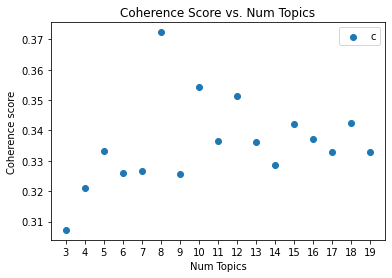

In [21]:
LIMIT=20; START=3; STEP=1

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=START, limit=LIMIT, step=STEP)

#Plot the graph of coherence scores across different number of topics (from start to limit).

import matplotlib.pyplot as plt

limit=20; start=3; step=1
x = range(START, LIMIT, STEP)
plt.scatter(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Score vs. Num Topics")
plt.legend(("coherence_values"), loc='best')
plt.xticks(x)
plt.show()



## Topic Visualization

In [22]:
#Parameter tuning will lead to different models. For this model, we use our corpus, dictionary, 
#set a random state of 100 (akin to setting a seed for reproduction purposes), 9 topics 
#(optimal number according to coherence scores), 100 passes (number of times the corpus is passed 
#through for training), and chunk size of 10 (number of documents to be used in each training chunk).

#See: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/. 

# How to optimize the interval, as in mallet (http://mallet.cs.umass.edu/topics.php)?
# --optimize-interval [NUMBER] This option turns on hyperparameter optimization, 
#which allows the model to better fit the data by allowing some topics to be more prominent than others. 
#Optimization every 10-20 iterations is reasonable. 

opt_topics = np.argmax(coherence_values) # + start
#print(coherence_values)
print("Topics maximizing coherence score: ", opt_topics + start)

lda_model = models.LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         random_state=100,
                         num_topics=opt_topics,
                         passes=100,
                         chunksize=10,
                         alpha="asymmetric"
                         )

# note alpha is hyperparameter

lda_model.show_topics()

Topics maximizing coherence score:  8
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

[(0,
  '0.009*"people" + 0.008*"indians" + 0.008*"nation" + 0.007*"would" + 0.007*"creeks" + 0.007*"states" + 0.006*"united" + 0.006*"peace" + 0.006*"towns" + 0.005*"may"'),
 (1,
  '0.012*"may" + 0.010*"nation" + 0.009*"states" + 0.008*"united" + 0.008*"people" + 0.008*"us" + 0.007*"father" + 0.006*"president" + 0.006*"wish" + 0.005*"line"'),
 (2,
  '0.000*"execute" + 0.000*"wit" + 0.000*"pursuance" + 0.000*"arthur" + 0.000*"formal" + 0.000*"enjoin" + 0.000*"daring" + 0.000*"accompanying" + 0.000*"namely" + 0.000*"believing"'),
 (3,
  '0.010*"states" + 0.010*"united" + 0.009*"indians" + 0.008*"treaty" + 0.008*"brothers" + 0.008*"commissioners" + 0.008*"general" + 0.008*"us" + 0.007*"nations" + 0.007*"may"'),
 (4,
  '0.010*"indians" + 0.009*"us" + 0.008*"treaty" + 0.008*"people" + 0.008*"states" + 0.007*"state" + 0.007*"congress" + 0.007*"commissioners" + 0.007*"may" + 0.006*"united"')]

In [23]:
# alternative syntax for LDA model

Lda = gensim.models.ldamodel.LdaModel
lda_model2 = Lda(corpus, 
                num_topics=opt_topics, 
                id2word = dictionary, 
                passes=100,
                iterations=200, 
                chunksize = 10, 
                eval_every = None)

# To show initial 15 topics with 10 top words from each
lda_model2.show_topics(15, num_words=10, formatted=False)

[(0,
  [('states', 0.009808262),
   ('indians', 0.009625346),
   ('united', 0.00912269),
   ('us', 0.008671526),
   ('may', 0.008129156),
   ('treaty', 0.0076349005),
   ('commissioners', 0.0071686404),
   ('people', 0.00661871),
   ('shall', 0.005984027),
   ('nation', 0.0055887224)]),
 (1,
  [('simcoe', 0.004032619),
   ('sandusky', 0.0034025698),
   ('months', 0.0032864253),
   ('dollars', 0.003201434),
   ('legion', 0.003112715),
   ('per', 0.002948308),
   ('glaize', 0.0028827158),
   ('upon', 0.002787224),
   ('america', 0.002777236),
   ('speech', 0.002675745)]),
 (2,
  [('people', 0.008761521),
   ('indians', 0.0080607245),
   ('nation', 0.007869473),
   ('would', 0.00723573),
   ('creeks', 0.0068384423),
   ('states', 0.0062759155),
   ('united', 0.0061520906),
   ('peace', 0.0057106186),
   ('towns', 0.0055805133),
   ('one', 0.005522793)]),
 (3,
  [('enjoin', 0.000103867234),
   ('pattawatiina', 0.00010386677),
   ('sac', 0.00010386635),
   ('sachems', 0.000103866034),
   ('

In [24]:
# Get all topics, which will exceed opt_topics

topics = list(lda_model.get_document_topics(corpus, minimum_probability=0))

# Print topic proportion in corpus
topic_ratios = []

for i in range(opt_topics): 
    ratio = 100*sum([pair[i][1] for pair in topics])/len(topics)
    print(f"Topic {i+1} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.3f}%")
    topic_ratios.append(ratio)
    
print(topic_ratios)

Topic 1 proportion: 24.916%
Topic 2 proportion: 10.008%
Topic 3 proportion: 0.033%
Topic 4 proportion: 43.854%
Topic 5 proportion: 21.188%
[24.916189400319126, 10.008396307844123, 0.03316098338700613, 43.85401565376924, 21.188237232790925]


In [25]:

def get_doc_index(doc_names, doc_name):
    '''
    Returns doc index given corpus of doc names, and given document name
    '''
    return doc_names.index(doc_name)


In [26]:
# Return top topics in a doc
def get_top_topics(doc_name, min_prob=0.00):
    
    doc_index = get_doc_index(doc_names, doc_name)
    # Sort topics from highest to lowest frequency
    topics = sorted(lda_model.get_document_topics(corpus[doc_index], minimum_probability=min_prob), key=lambda tup: tup[1])[::-1]

    # Get word distribution for each topic
    pairs = [lda_model.show_topic(pair[0]) for pair in topics]
    topic_words = [[pair[0] for pair in topic] for topic in pairs]
    print("len, ", )

    return pd.DataFrame({'Major Topics': topics,'Topic Words': topic_words})

In [27]:
print(doc_names[:10])
topic_sample = get_top_topics('ASP-IA-v1-41', 0.10)
display(topic_sample)


['ASP-IA-v1-82', 'ASP-IA-v1-96', 'ASP-IA-v1-41', 'ASP-IA-v1-55', 'ASP-IA-v1-69', 'ASP-IA-v1-2', 'ASP-IA-v1-3', 'ASP-IA-v1-68', 'ASP-IA-v1-54', 'ASP-IA-v1-40']
len, 


,Major Topics,Topic Words
0,"(0, 0.9999299)","[people, indians, nation, would, creeks, state..."


### py LDA Visualization

In [ ]:
# Create Topic Table

all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds = 'pcoa', sort_topics=False)

for i in range(1, opt_topics): #Adjust this to reflect number of topics chosen for final LDA model
    topic = vis.topic_info[vis.topic_info.Category == 'Topic'+ str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd) + topic['logprob']*lambd
    all_topics['Topic '+ str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

all_topics = pd.DataFrame(all_topics).T
display(all_topics)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# corpus in form: list[tuple[list[tuple(a, b)]]]
# print(corpus[:1][0:5])

pyLDAvis.enable_notebook()
#vis2 = pyLDAvis.gensim.prepare(lda_model2, corpus, dictionary)
pyLDAvis.display(vis)

# **Using Mallet Raw**

In [ ]:
print(mallet_path)

In [ ]:
################### RUN ME #################
# import data

import os

os.chdir(mallet_path)
!pwd
!bin/mallet import-dir --input English_Sample --output English_model.mallet --keep-sequence --stoplist-file en-stop-oa.txt

In [ ]:
################### RUN ME #################
# creating a model for topic modeling
TOPICS = opt_topics
OPT_INT = 10
ALPHA = 1.0

'''
Other flags for train-topics:
--num-iterations
--input-state
--optimize-burn-in (num iters before hyperparam opt begins)
'''

!bin/mallet train-topics --input English_model.mallet --num-topics $TOPICS --optimize-interval $OPT_INT \
--word-topic-counts-file output-topic-counts.txt --output-state output-topics-state.gz \
--output-topic-keys output_keys.txt --output-doc-topics output_composition.txt

In [ ]:
# CREATE model inferencer for topic modeling on new documents

MODEL_PATH = "/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/Mallet/English_model.mallet"
INPUT_DATA = "Algerian_War_wiki.txt"

# Run topic inference on the input data
!bin/mallet infer-topics \
    --input $INPUT_DATA \
    --inferencer $MODEL_PATH/inferencer.mallet \
    --output-doc-topics $MODEL_PATH/doc_topics.txt \
    --num-iterations 1000 \
    --optimize-interval 10 \
    --output-state $MODEL_PATH/state.gz \
    --random-seed 1 \
    --num-top-words 20

'''
bin/mallet infer-topics \
    --input "Algerian_War_wiki.txt" \
    --inferencer French_model.mallet/inferencer.mallet \
    --output-doc-topics French_model.mallet/doc_topics.txt \
    --num-iterations 1000 \
    --optimize-interval 10 \
    --output-state French_model.mallet/state.gz \
    --random-seed 1 \
    --num-top-words 20
'''

In [ ]:
# train a model for doc classification
# other languages: de.sequences en.sequences
!bin/mallet run cc.mallet.topics.PolylingualTopicModel \ 
--language-inputs fr.sequences \ 
--num-topics $TOPICS --alpha $ALPHA

In [ ]:
# tune hyperparameters for topic modeling

bin/mallet run cc.mallet.topics.PolylingualTopicModel \ 
--language-inputs fr.sequences \
--num-topics $TOPICS --alpha $ALPHA --optimize-interval $OPT_INT --optimize-burn-in 20

'''
bin/mallet run cc.mallet.topics.PolylingualTopicModel \ 
--language-inputs fr.sequences \
--num-topics 13 --alpha 1.0 --optimize-interval 10 --optimize-burn-in 20
'''

In [ ]:
# create topic influencer files for generalizing topics on new documents CLASSIFICATION

bin/mallet run cc.mallet.topics.PolylingualTopicModel \ 
  --language-inputs fr.sequences \
  --num-topics $TOPICS --alpha $ALPHA --optimize-interval $OPT_INT --optimize-burn-in 20 \
  --inferencer-filename inferencer

'''
bin/mallet run cc.mallet.topics.PolylingualTopicModel \ 
  --language-inputs fr.sequences \
  --num-topics 13 --alpha 1.0 --optimize-interval 10 --optimize-burn-in 20 \
  --inferencer-filename Inferencer_french
'''

# **Processing Mallet Output**

In [ ]:
import pandas as pd

key_path = "/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/Mallet/output_keys.txt"
topics = pd.Cov = pd.read_csv(key_path, sep='\t', names=["topic_number", "topic_weight", "top_words"])

topics.style.set_properties(subset=['top_words'], **{'width': '600px'})

# Create a list of topic labels.
labels = ['Ott-Tribe Negotiations', 'Tun-Alg Conflict','Public Works', 'Internal Discord', 'French Concess', 'Rebellions', 'Lead & Trans', 'Malfeasance', 'Religion & Gov', 'Battle of Con.', 'Eng Bomb_BadGov', 'Topic 12', 'Topic 13']

# Add the labels list as a new column to the dataframe
topics['labels'] = labels

topics.head()



In [ ]:
# Represent the weights of the topics as a simple bar chart, using the author-created topic labels. 

topic_bar = topics.plot.bar(x='labels', y='topic_weight', rot=0, figsize=(20,5))

# set labels, title and color
topic_bar.set_xlabel('Topics')
topic_bar.set_ylabel('Weights')
topic_bar.set_title('Topical Weights')

In [ ]:
import matplotlib.pyplot as plt
import squarify

plt.rcParams['figure.figsize'] = (17.0, 10.0)

squarify.plot(sizes=topics['topic_weight'], label=topics['labels'], alpha=.8)
plt.axis('off')
plt.show()

In [ ]:
# The mallet .txt doc-topics output file was converted to a csv, and the columns for 
# document numbers and filepaths were deleted in advance of reading the csv into a 
# pandas dataframe. Be sure to convert the columns to number data type with ~6 decimal places to remove the 
# exponential format. Also, add a new line at the top of the csv with the labels defined in the previous step.

output_comps = "/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/Mallet/output_composition.txt"
remove = "file:/Users/aaron68lee/Documents/Coding-Projects/NLP-Research/Mallet/FRconquest_split/"

doc_topic_matrix = pd.Cov = pd.read_csv(output_comps, sep='\t')
num_labels = len(labels)
filenames = []

# create an empty dataframe with desired columns
df = pd.DataFrame(columns=['filename'] + labels)

# open and read the text file
with open(output_comps, 'r') as file:
    # iterate through each line in the file
    for line in file:
        # split the line into text and label using a delimiter
        row = line.strip().split('\t')
        row = row[1:]

        filepath = row[0]
        filename = os.path.basename(filepath)
        filenames.append(filename)
        '''
        print(len(row))
        print(df.shape)
        print(line)
        #print("text: ", row)
        #print(filename)
        '''
        vals = [float(i) for i in row[1:]]
        df.loc[len(df)] = [filename] + vals

#print(df.iloc[0])
print(df.head())

# Save the dataframe as a CSV file
df.to_csv('topic_composition.csv', index=True)



In [ ]:
# Represent the topic weights in each document as a heatmap.
#!pip3 install seaborn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (17.0, 10.0)
#print(df.columns)

# drop non-numeric columns
#heatmap = df[df.columns.values].astype(float)
df_heat = df.drop(df.columns[0], axis=1)

'''
print("Columns: ", df.columns.values)

'''
#print(type(df_heat.iloc[0][0]))
# Create a heatmap that is visually accessible (see https://matplotlib.org/tutorials/colors/colormaps.html)
# using the 'inferno' colormap. 

'''
# Check for non-float illegal values
# select columns with non-float values
non_float_cols = df_heat.select_dtypes(exclude=['float']).columns
# select rows with non-null non-float values
non_float_rows = df_heat.loc[:, non_float_cols].notna().sum(axis=1) > 0
# print the non-float values
print(df_heat.loc[non_float_rows, non_float_cols])
'''

sns.heatmap(df_heat, cmap='inferno', vmin=0.0, vmax=1.0)

In [ ]:
# Create a hierarchical heatmap using seaborn's "clustermap" method with default settings.
# By default this method will cluster by both rows and columns, which is what is most useful for this data.

sns.clustermap(df_heat, cmap='inferno')

In [ ]:
# sort dataframe csv by specifying a topic

print(labels)
topic = labels[0]
topic = 'Ott-Tribe Negotiations'
df_heat.sort_values(topic, ascending=False).head()

In [ ]:
#There is a known bug when using the suggested method (IPython.display.IFrame) in Jupyter Notebooks, but
#the following code will actually render the desired iframe in notebooks without a problem.

# Voyant visualizer

import IPython
url = 'https://voyant-tools.org/?corpus=80d0e68d144f5d3bb792fb0ddb115833&view=Contexts&query=juif*&context=10'
iframe = '<iframe src=' + url + ' width=960 height=569></iframe>'
IPython.display.HTML(iframe)

In [14]:
# modify authorcount for own purposes
# index is pie chart legend
'''
df = pd.DataFrame({'AuthorCount': [27, 13, 2]},
    index=['Mercier', 'Vayssettes', 'Gaid'])
plot = df.plot.pie(y='AuthorCount', figsize=(7, 7))
'''

"\ndf = pd.DataFrame({'AuthorCount': [27, 13, 2]},\n    index=['Mercier', 'Vayssettes', 'Gaid'])\nplot = df.plot.pie(y='AuthorCount', figsize=(7, 7))\n"

# **Sentiment Analysis**

## Using Bart LLM

In [15]:
import torch
from transformers import AutoTokenizer, BartForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("valhalla/bart-large-sst2")
model = BartForSequenceClassification.from_pretrained("valhalla/bart-large-sst2", num_labels=2) # binary sentiment classification

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
print(inputs)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


{'input_ids': tensor([[    0, 31414,     6,   127,  2335,    16, 11962,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [16]:
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]
print("Predicted Sentiment: ", predicted_class_id)

# To train a model on `num_labels` classes, you can pass `num_labels=num_labels` to `.from_pretrained(...)`
num_labels = len(model.config.id2label)
model = BartForSequenceClassification.from_pretrained("valhalla/bart-large-sst2", num_labels=num_labels)

labels = torch.tensor([1])
loss = model(**inputs, labels=labels).loss
round(loss.item(), 2)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


Predicted Sentiment:  1


0.0

# **Text Summarization**

## Extractive Summarization Using LSA

In [17]:
import gensim
from gensim import *
import tensorflow as tf

# assume variable 'docs' defined from previous cells (preprocessing)
# summarize() is obsolete as of gensim 4.0

## Comparing Generative Summarization with Various GPTs

### Verify HuggingFace API

In [18]:
import requests

huggingface_key = get_api_key(api_file)
'''
# Get authentication credentials
username = getpass("Hugging Face username: ")
password = getpass("Hugging Face password: ")
'''

NameError: name 'get_api_key' is not defined

### BART (beta)

In [ ]:
# Chunk each doc into groups of sentences that don't exceed length of attention head

# initialize
length = 0
chunk = ""
all_chunks = []
count = -1


tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

for i, doc in enumerate(sample_doc_str): # replace with doc_strings
    
    sentences = nltk.tokenize.sent_tokenize(doc)
    chunks = []
    for sentence in sentences:
      count += 1
      combined_length = len(tokenizer.tokenize(sentence)) + length # add the no. of sentence tokens to the length counter

      if combined_length <= tokenizer.max_len_single_sentence: # if it doesn't exceed
        chunk += sentence + " " # add the sentence to the chunk
        length = combined_length # update the length counter

        # if it is the last sentence
        if count == len(sentences) - 1:
          chunks.append(chunk.strip()) # save the chunk

      else: 
        chunks.append(chunk.strip()) # save the chunk

        # reset 
        length = 0 
        chunk = ""

        # take care of the overflow sentence
        chunk += sentence + " "
        length = len(tokenizer.tokenize(sentence))
        
    all_chunks.append(chunks)

In [ ]:
import torch
import transformers
#import tensorflow as tf
from transformers import pipeline, BartForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BartTokenizer, BartForConditionalGeneration, BartConfig

print("Transformers version: ", transformers.__version__)

# IMPORTANT RUN THIS COMMAND IN CMD: huggingface-cli login --token <insert token>

    
# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
# model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn", use_auth_token=(username, password)  # Pass authentication credentials

# Initializing the model & tokenizer using .from_pretrained()
'''
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained('bart-large-cnn')
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained('bart-large-cnn')
model = BartForSequenceClassification.from_pretrained

'''

print("HuggingFace Bart initialized.")

# generate summaries of all docs in corpus

summarizer = pipeline(task="summarization") #, model=model, tokenizer=tokenizer) # do_sample=False
#summarizer = pipeline(task="summarization", model='bart-large-cnn', tokenizer='bart-large-cnn') 
print(summarizer)

summaries = []
sample_doc_str = doc_strings[0:2]

for i, doc in enumerate(sample_doc_str): # replace with doc_strings
    summary = summarizer(doc, min_length=10, max_length=100)
    summary = summary[0]['summary_text']
    print(summary)
    # summaries.append(summary)
    # encode the input in chunks if doc too long
    

    '''
    # Use BART or Glove
    inputs = [tokenizer(chunk, return_tensors="pt") for chunk in chunks]

    inputs = tokenizer.batch_encode_plus([doc], max_length=1024*8, return_tensors='pt', truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=100, early_stopping=False)
    summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    print(i, " | Original Len: ", len(doc),'------>' , "Summary Len: ", len(summary_text))
    print(summary_text)
    print("\n")
    '''

#print(summaries[0][:20])

### T5 Transformer

In [ ]:
# Importing requirements
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration

# Instantiating the model and tokenizer 
my_model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

summaries = []

for doc in doc_strings:
    # since T5 has encoder-decoder architecture, input text must be sequence of ids
    input_ids = tokenizer.encode("summarize:" + doc, return_tensors='pt', max_length=512)
    
    # transformers.PreTrainedModel.generate (input_ids=None, max_length=None, min_length=None, num_beams=None)
    summary_id = my_model.generate(input_ids)
    t5_summary = tokenizer.decode(summary_id[0])
    
    summaries.append(t5_summary)
    

In [ ]:
# print some summaries of documents

max_summaries = 5

for i, summary in enumerate(summaries):
    if i < max_summaries:
        print(summary)

### GPT-2

In [ ]:
# Importing model and tokenizer
from transformers import GPT2Tokenizer,GPT2LMHeadModel

warnings.filterwarnings('ignore')

# Instantiating the model and tokenizer with gpt-2
tokenizer=GPT2Tokenizer.from_pretrained('gpt2')
model=GPT2LMHeadModel.from_pretrained('gpt2')

def get_summaries(doc_strings):
    '''
    Input:
        doc_strings: list of docs as single strings per doc (will tokenize later)
    Output:
        summaries: list of generated summaries for each doc from GPT-2
    '''
    summaries = []

    for doc in tqdm(doc_strings, desc="Summarizing", unit="item"):

        # Encoding text to get input ids & pass them to model.generate()
        inputs=tokenizer.batch_encode_plus([doc],return_tensors='pt',max_length=512)
        summary_ids=model.generate(inputs['input_ids'],early_stopping=True)
        GPT_summary=tokenizer.decode(summary_ids[0],skip_special_tokens=True)

        summaries.append(GPT_summary)

    print("Done generating summaries")
    return summaries

summaries = get_summaries(doc_strings)

In [ ]:
# print some summaries of documents

max_summaries = 1

for i, summary in enumerate(summaries):
    if i < max_summaries:
        print(summary)

In [ ]:
# add more transformer models from HuggingFace here


# **Text Generation (Google Colab GPU)**

## Text Completion (Use Google Colab for GPU)

In [ ]:
from transformers import GPT2Tokenizer
from transformers import GPT2DoubleHeadsModel

tokenizer=GPT2Tokenizer.from_pretrained('gpt2-medium')
model=GPT2DoubleHeadsModel.from_pretrained('gpt2-medium')

In [ ]:
import torch

print(torch.__version__)

text = original_docs[0]
text = "The monkey likes eating the"
ids=tokenizer.encode(text)
my_tensor=torch.tensor([ids])

# Setting model in eval mode
model.eval()

result=model(my_tensor)
predictions=result[0]

predicted_index = torch.argmax(predictions[0, -1, :]).item()

predicted_text = tokenizer.decode(ids + [predicted_index])

print(predicted_text)

In [ ]:
def complete_text(text, n_words):
    '''
    Complete generation of n_words from a given prompt
    Returns: completed generated text including prompt
    '''
    for i in tqdm(range(n_words), desc='Generating Text', unit='word'):
        # encode the input text
        input_ids = tokenizer.encode(text)
        # convert into a tensor
        input_tensor = torch.tensor([input_ids])

        # passing input tensor to model
        result = model(input_tensor)
        # storing all predicted ids of next word
        predictions = result[0]
        # Choosing the predicted_index (og maximum value)
        predicted_index = torch.argmax(predictions[0,-1,:]).item()
        # decoding the predicted index to text and concatenating to original text
        text = tokenizer.decode(input_ids + [predicted_index])
        
    return text

In [ ]:
text = complete_text("the monkey likes to", 2)
print(text)

## QA 

In [ ]:
# Import pipeline from transformers
from transformers import pipeline

def QA(question, context):
    '''
    Given question and context
    Returns: Answer and its score from [0, 1]
    '''
    # Create a question-answering pipeline
    faq_machine = pipeline(task="question-answering", disable_progress_bar=False)
    '''
    # Other Types of tasks:
        text classification
        NER
        sentiment analysis
        text generation
        text summarization
        translation
        QA
    '''
    ans = faq_machine(question=question,context=context)
    return ans['answer'], ans['score']

In [ ]:
context = original_docs[0]
question = "How much money did the activities cost?"

answer, score = QA(question, context)
print('Answer:', answer)
print('Score:', score)

# Semantic Analysis and Document-level Understanding (Google Colab)

In [ ]:
print(original_docs[0])

# **Translation**

In [ ]:
from transformers import pipeline

lang = "translation_en_to_fr"
translator_model=pipeline(task=lang) # change task as needed

'''
English to French: pipeline(task='translation_en_to_fr')
English to German: pipeline(task='translation_en_to_de')
English to Spanish: pipeline(task='translation_en_to_es')
English to Portuguese: pipeline(task='translation_en_to_pt')
English to Italian: pipeline(task='translation_en_to_it')
English to Russian: pipeline(task='translation_en_to_ru')
English to Japanese: pipeline(task='translation_en_to_ja')
English to Korean: pipeline(task='translation_en_to_ko')
English to Chinese: pipeline(task='translation_en_to_zh')
'''

translator_model

In [ ]:
translation = translator_model('I welcome you to my country ! I am sure you will enjoy your visit')

# translation is a dictionary
print(translation)

## Using Seq2Seq Models for Translation Prediction

### Model Arguments

In [ ]:

model_args = {'adam_epsilon': 1e-08,
 'base_marian_model_name': 'Helsinki-NLP/opus-mt-en-ro',
 'best_model_dir': 'outputs/best_model',
 'cache_dir': 'cache_dir/',
 'config': {},
 'dataset_class': None,
 'do_lower_case': False,
 'do_sample': False,
 'early_stopping': True,
 'early_stopping_consider_epochs': False,
 'early_stopping_delta': 0,
 'early_stopping_metric': 'eval_loss',
 'early_stopping_metric_minimize': True,
 'early_stopping_patience': 3,
 'encoding': None,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'evaluate_during_training_steps': 2000,
 'evaluate_during_training_verbose': True,
 'evaluate_generated_text': True,
 'fp16': False,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 4e-05,
 'length_penalty': 2.0,
 'logging_steps': 50,
 'manual_seed': 4,
 'max_grad_norm': 1.0,
 'max_length': 50,
 'max_seq_length': 50,
 'max_steps': -1,
 'model_name': 'Helsinki-NLP/opus-mt-en-ro',
 'model_type': 'marian',
 'multiprocessing_chunksize': 500,
 'n_gpu': 1,
 'no_cache': False,
 'no_save': False,
 'num_beams': 1,
 'num_train_epochs': 10,
 'output_dir': 'outputs/',
 'overwrite_output_dir': True,
 'process_count': 1,
 'repetition_penalty': 1.0,
 'reprocess_input_data': True,
 'save_best_model': True,
 'save_eval_checkpoints': False,
 'save_model_every_epoch': False,
 'save_steps': 2000,
 'silent': False,
 'tensorboard_dir': None,
 'train_batch_size': 2,
 'use_cached_eval_features': False,
 'use_cuda': False,
 'use_early_stopping': False,
 'use_multiprocessing': False,
 'wandb_kwargs': {},
 'wandb_project': None,
 'warmup_ratio': 0.06,
 'warmup_steps': 0,
 'weight_decay': 0}

### Seq2Seq Model

In [ ]:
import torch
from simpletransformers.seq2seq import Seq2SeqModel

model = Seq2SeqModel(encoder_decoder_type="marian",encoder_decoder_name="Helsinki-NLP/opus-mt-en-ro",args=model_args,use_cuda=False)
# see list of pretrained models: https://huggingface.co/transformers/pretrained_models.html

In [ ]:

translation = model.predict(['I welcome you to my country','I am sure you will enjoy your stay here'])
print(translation)

# Training Custom Word2Vec Models

## Computing Vector Embeddings

In [29]:
#your "sentences" object with the cleaned text data. 
from transformers import pipeline
from gensim.models import Word2Vec, Phrases

bigram_transformer = phrases.Phrases(docs) 
bigram = phrases.Phraser(bigram_transformer)

model = Word2Vec(bigram[docs], workers=4, sg=0, min_count=5, window=5, sample=1e-3) #size=700 # N-dimensions

model.init_sims(replace=True) #Precompute L2-normalized vectors. If replace is set to TRUE, forget the original vectors and only keep the normalized ones. Saves lots of memory, but can't continue to train the model.
model.save("./Word2Vec_Models/English_Sample") #save your model for later use! change the name to something to remember the hyperparameters you trained it with
model =  Word2Vec.load("./Word2Vec_Models/English_Sample") #name of YOUR model here, or file path to your 
# Load Google News Word2Vec Model
#model = KeyedVectors.load_word2vec_format('./Word2Vec_Models/GoogleNews-vectors-negative300.bin.gz', limit=500000, binary=True)  

vocab = list(model.wv.key_to_index.keys())

with open("./Word2Vec_Models/eng_vocab.txt", "w") as f:
    for word in vocab:
        f.write(word + "\n")
print("Model Complete")

Model Complete


In [30]:
def get_vector(model, word):
    '''
    Model must be gensim object Word2Vec model
    Returns word vector if key present in its vocab
    '''
    try: 
        vect = model.wv.get_vector(word)
    except:
        vect = None
        print("Word not in model vocabulary")
    return vect

def cossim(model, word_1, word_2):
    # make sure both words in Word2Vec model
    vocab = list(model.wv.key_to_index.keys())
    if word_1 and word_2 in vocab:
        return (1 - spatial.distance.cosine(model.wv[word_1], model.wv[word_2])) 
    else:
        print("At least one word not in model vocab")
        

def n_most_similar_words(model, words, neg=None, n=10):
    '''
    negative is a list of words opposite of most similar n words
    '''
    vocab = list(model.wv.key_to_index.keys())
    if (neg is None) and all(w in vocab for w in words):
        return model.wv.most_similar(words, topn=n)
    elif (word is None) and all(n in vocab for n in neg):
        return model.wv.most_similar(negative=neg, topn=n)
    elif all(w in vocab for w in words) and all(n in vocab for n in neg):
        return model.wv.most_similar(positive=words, negative=neg, topn=n)
    else:
        print("Words not in model vocabulary")
        return None
    
def cbow(model, context_words, n):
    # Predict the most similar n words
    vocab = list(model.wv.key_to_index.keys())
    if all(w in vocab for w in context_words):
        predicted_words = model.predict_output_word(context_words, topn=n+len(context_words))
        predicted_words = [word for word in predicted_words if word[0] not in context_words]
        return predicted_words[:n]
    else:
        print("Words not in model vocabulary")
        return None

In [31]:
context = ['village', 'indian']
predictions = cbow(model, context, 5)

print(predictions)

[('river', 0.00014288009), ('mouth', 0.0001426146), ('thence', 0.0001411197), ('miles', 0.00013839296), ('east', 0.00013548147)]


In [51]:
vector = get_vector(model, "indians")
#print(vector)

similarity = cossim(model, "men", "peace")
print(similarity)
similarity = cossim(model, "women", "peace")
print(similarity)

top_sim = n_most_similar_words(model, ["indians"], neg=['peace'])
print(top_sim)

0.22837530076503754
0.46435460448265076
[('ilolston', 0.7330849170684814), ('one_thousand', 0.6933737397193909), ('indian', 0.6847668886184692), ('tanner', 0.6814879179000854), ('creek', 0.6612646579742432), ('eight_hundred', 0.6269149780273438), ('year', 0.6200418472290039), ('mississinewa', 0.6197043657302856), ('seven_hundred', 0.605331540107727), ('acres', 0.6014543771743774)]


In [33]:
def odd_words(model, string):
    return model.wv.doesnt_match(string.split())

word = odd_words(model, "america indians art cherokees")
print(word)

indians


In [56]:
def get_vector_context(model, w1, w2, w3):
    
    vocab = list(model.wv.key_to_index.keys())
    if w1 not in vocab:
        print(w1, "not found in vocab")
        return
    if w2 not in vocab:
        print(w2, "not found in vocab")
        return
    if w3 not in vocab:
        print(w3, "not found in vocab")
        return
    
    context = model.wv[w1] - model.wv[w2]
    vector = context.reshape(1, -1)[0]
    query = model.wv[w3].reshape(1,-1)
    similarity = cosine_similarity(context.reshape(1,-1), query)[0][0]

    # Normalize the vector
    normalized_vector = vector / np.linalg.norm(vector)

    # Find the most similar word
    most_similar_word = model.wv.most_similar([normalized_vector], topn=5)
    score = most_similar_word[0][1]
    #model.wv.key_to_index[model.wv.most_similar([normalized_vector], topn=1)[0][0]]

    return vector, most_similar_word, similarity, score

vector, answer, similarity, score = get_vector_context(model, "americans", "kill", "men")

print("Closest Analogy:", answer)
print("Similarity:", similarity)
print("Analogy Score:", score)

Closest Analogy: [('couched', 0.6783740520477295), ('headman', 0.6239572763442993), ('advocate', 0.5393767952919006), ('answer', 0.5345953702926636), ('beloved_town', 0.5265207290649414)]
Similarity: -0.0042282827
Analogy Score: 0.6783740520477295


## Visualizing Word-Vector Neighborhoods Using Clustering

In [40]:
#review of tsne: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
#modified code from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne/code

#define a function to visualize word-vectors in 2-D version of the high dimensional space

def tsne_plot(model, words, word_axes=None, topn=30, n_comp=2, 
              title="TSNE Visualization of Word-Vectors", logdir='./Tensorboard', metadata_file='metadata.tsv',
              iterations=3000, seed=0): 
    '''
    Params:
        word_axes: [pos=[], neg=[]] list of axes for rate similar words
    '''
    
    filtered_words = []
    word_vectors = []
    label=[]

    if word_axes is None:
        for word in words:   
            try:
                word_vectors.append(model.wv[word])
                filtered_words.append(word)
            except KeyError: #if one of the words_to_explore is not in the model vocab, just skip it
                continue
    
    # axis word polar filter
    if word_axes is not None:
        top_sim_1 = n_most_similar_words(model, word_axes[0], word_axes[1], n=topn)
        top_sim_2 = n_most_similar_words(model, word_axes[1], word_axes[0], n=topn)
        if top_sim is not None:
            for i in top_sim_1: # axis 1
                
                filtered_words.append(i[0])
                word_vectors.append(model.wv[i[0]])
                label.append('Positive')

            for i in top_sim_2: # axis 2
                
                filtered_words.append(i[0])
                word_vectors.append(model.wv[i[0]])
                label.append('Negative')
    
    "Creates and TSNE model and plots it"
    tsne_model = TSNE(perplexity=5, n_components=n_comp, init='pca', n_iter=iterations, random_state=seed) 
    #you may need to tune these, epsecially the perplexity. #Use PCA to reduce dimensionality to 2-D, an "X" and a "Y 
    
    # Word vectors must be numpy array with .shape attribute
    word_vectors = np.array(word_vectors)
    new_values = tsne_model.fit_transform(word_vectors)
    
    # Launch Tensorboard Projection Visualizer
    
    # Create a TensorFlow Variable to hold the embeddings
    embeddings_var = tf.Variable(new_values, name='embeddings')

    # Save the embeddings as a .tsv file
    np.savetxt(logdir + '/embeddings.tsv', new_values, delimiter='\t')
    
    # Initialize the TensorFlow session and the variable
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())

        # Save the word labels (metadata) to a file
        with open(logdir + '/' + metadata_file, 'w') as f:
            for word in filtered_words:
                f.write(word + '\n')

        # Create the projector configuration
        config = projector.ProjectorConfig()
        embedding = config.embeddings.add()
        embedding.tensor_name = embeddings_var.name
        embedding.metadata_path = metadata_file

        # Save the projector configuration
        projector.visualize_embeddings(logdir, config)

        # Save the TensorFlow trained model
        #saver = tf.compat.v1.train.Saver()
        #saver.save(sess, logdir + '/model.ckpt')
        
        # Create a summary writer to write the embeddings
        summary_writer = tf.compat.v1.summary.FileWriter(logdir)
        summary_writer.add_graph(sess.graph)

        # Save the embeddings in the summary writer
        projector.visualize_embeddings(summary_writer, config)
        print("Projections saved")

    # Launch TensorBoard
    print("To visualize the embeddings, run the following command:")
    print(f"tensorboard --logdir={logdir}")
    
    # Tensorboard URL:
    #url = notebook.display(port=6006, height=500)
    url = f'http://projector.tensorflow.org/?config=https://raw.githubusercontent.com/aaron68lee/NLP-Topic-Modeling-of-Corpora/main/{logdir[2:]}/projector_config.pbtxt'
    
    # Create Embedded Plot of Projection
    
    MAX_POINTS=60
    if n_comp == 3:
        x = new_values[0:MAX_POINTS, 0]
        y = new_values[0:MAX_POINTS, 1]
        z = new_values[0:MAX_POINTS, 2]

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(x, y, z, c='b', marker='o')

        for i in range(len(x)):
            ax.text(x[i], y[i], z[i], filtered_words[i])

        ax.set_xlabel("Latent Dimension 1")
        ax.set_ylabel("Latent Dimension 2")
        ax.set_zlabel("Latent Dimension 3")
        ax.set_title(title)
        plt.savefig('tsne_word2vec_3D.png')
    else:
        x = []
        y = []
        for value in new_values[0:MAX_POINTS]:
            x.append(value[0])
            y.append(value[1])

        plt.figure(figsize=(10, 10)) 
        for i in range(len(x)):
            plt.scatter(x[i],y[i])
            plt.annotate(filtered_words[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
        plt.ylabel("Latent Dimension 1") #Some pyplot reminders: https://matplotlib.org/users/pyplot_tutorial.html
        plt.xlabel("Latent Dimension 2")
        plt.title(title)
        plt.savefig('tsne_word2vec_2D.png')
    
    plt.show()


In [41]:
print(len(vocab))

15245


Projections saved
To visualize the embeddings, run the following command:
tensorboard --logdir=./Tensorboard


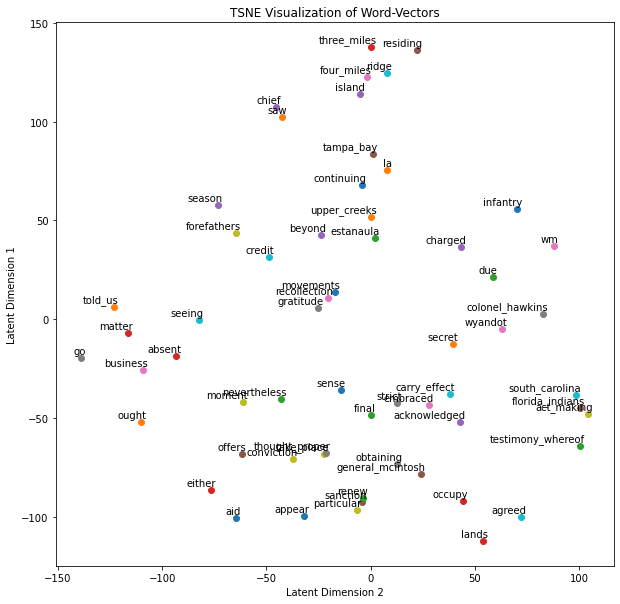

In [57]:
word_axes = [['war'], ['happy', 'peace']]
vocab = list(model.wv.key_to_index.keys())
words = vocab[0:3000]
words = random.sample(words, len(words))  # random.shuffle(words) # 

tsne_plot(model, words, word_axes=None, topn=10, n_comp=2)

In [44]:
def word2vec2tensor(model, tensor_filename):
    outfiletsv = tensor_filename + '_tensor.tsv'
    outfiletsvmeta = tensor_filename + '_metadata.tsv'
                
    with smart_open(outfiletsv, 'wb') as file_vector, smart_open(outfiletsvmeta, 'wb') as file_metadata:
        for word in model.wv.index2word:
            word = stem_dict[word] if stem_dict.get(word) else word
            file_metadata.write(gensim.utils.to_utf8(word) + gensim.utils.to_utf8('\n'))
            vector_row = '\t'.join(str(x) for x in model.wv.__getitem__(word))
            file_vector.write(gensim.utils.to_utf8(vector_row) + gensim.utils.to_utf8('\n'))

## K-Means Clustering on Word2Vec

In [ ]:
print(len(docs))

In [58]:
'''
Modify to load feature vectors from Word2Vec Model
Using LDA produces more accurate topic models than clustering vocab across documents

'''

# perform clustering algorithms on each user's video data
vectors = pd.DataFrame(np.load(feature_vectors_1))

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(vectors)

pca = PCA(n_components=3)
projected_vectors = pca.fit_transform(vectors)

# Save the cluster labels and projected vectors as TSV files
np.savetxt('./Data/clusters.tsv', cluster_labels, delimiter='\n', fmt='%d', encoding='utf-8')
np.savetxt('./Data/projected_vectors.tsv', projected_vectors, delimiter='\t', fmt='%.6f', encoding='utf-8')

# Save the cluster labels and video titles as a TSV file
with open('./Data/labeled_data.tsv', 'w', encoding='utf-8') as f:
    headers = ["Cluster", "Word"]
    f.write('\t'.join(headers) + '\n')  # Write the headers
    for label, word in zip(cluster_labels, vocab):
        f.write('{}\t{}\n'.format(label, word))
        

# Path to the TSV file
tsv_file = "./Data/labeled_data.tsv"

# Read the TSV file into a DataFrame
df = pd.read_csv(tsv_file, sep="\t") #skiprows=[0])

display(df.head())
# Group the video names by cluster number
grouped_clusters = df.groupby("Cluster")["Word"].apply(list)

# Create a separate text file for each cluster
ratios = []
for cluster_number, video_names in grouped_clusters.items():
    cluster_filename = f"./Clustered Words/cluster_{cluster_number}.txt"
    with open(cluster_filename, "w") as f:
        f.write("\n".join(vocab))

    ratios.append(round(len(vocab) / len(df), 3))
    print(f"Created {cluster_filename} containing {len(vocab)} doc names.")


NameError: name 'feature_vectors_1' is not defined

## Assessing Word Embedding Analogies and Connotations

In [ ]:
#Function to visualize testing accuracy:

from Testing import dimension
from Testing import build_lexicon

def acc_plot(testing_dimension, dimension_lexicon):
    '''
    Params:
        dimension_lexicon: established polar word axis
    '''
    rcParams['figure.figsize'] = 9,9
    
    myplot= stripplot(testing_dimension.testaccuracy()[3], dimension_lexicon.pos_test + dimension_lexicon.neg_test , testing_dimension.testaccuracy()[1], size=10)
    L= plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
               ncol=2, shadow=True, title="True Class", fancybox=True)
    plt.ylabel("Testing Words")
    plt.xlabel("Cosine similarity to dimension, possible range -1 (" + dimension_lexicon.neg_label + ") to +1 (" + dimension_lexicon.pos_label + ")" )
    L.get_texts()[0].set_text(dimension_lexicon.neg_label)
    L.get_texts()[1].set_text(dimension_lexicon.pos_label)
    
    plt.axvline(x=0, color='red', linestyle='dashed')
    plt.title("Cosine similarity between testing words and "+ str(testing_dimension.semantic_direction.direction_of_interest) + " dimension" )
    myplot.grid(b=True, linestyle='dashed')
    plt.show()

In [ ]:
'''
genderwords = build_lexicon.dimension_lexicon_builtin('gender', model) 
healthwords = build_lexicon.dimension_lexicon_builtin('health', model) 
seswords = build_lexicon.dimension_lexicon_builtin('ses', model) 
puritywords = build_lexicon.dimension_lexicon_builtin('purity', model, min_count=50)  

#for validation
mfdwords = build_lexicon.dimension_lexicon_builtin('moral_mfd', model, min_count=50) 
genderbolukwords = build_lexicon.dimension_lexicon_builtin('genderboluk', model) 

#Do visualization
acc_plot(gender, genderwords) #change this to a dimension lexicon and corresponding set of words
acc_plot(health, healthwords) 
acc_plot(ses, seswords) 
acc_plot(purity, puritywords) 

'''

In [ ]:
# Test Custom Word2Vec model on Google Analogy Test
# Framework derived from https://github.com/arsena-k/Word2Vec-bias-extraction/

accuracy_sections = model.wv.evaluate_word_analogies('./Testing/questions-words.txt')

accuracy_labels = [section['section'] for section in accuracy_sections[1]]
accuracy_tracker = []

for section in accuracy_sections[1]:
    #print(section)
    correct = len(section['correct'])
    incorrect = len(section['incorrect'])
    total = correct + incorrect
    if total == 0:
        accuracy = 0
    else:
        accuracy = float(correct) / total
    #print("Accuracy on " + str(section['section']) + ": " + str(accuracy))
    accuracy_tracker.append(accuracy)

analogy_accuracies = pd.DataFrame({"Category Label": accuracy_labels, "Accuracy": accuracy_tracker})
display(analogy_accuracies)
print('\033[1m' + "Average Accuracy On a Section: " + str(sum(accuracy_tracker) / len(accuracy_tracker)) + '\033[0m')


# **Document Similarity**

## Using Doc2Vec

In [ ]:
# Use Doc2Vec strategy

import gensim
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

docs_head = '\n'.join([' '.join(doc[:10]) for doc in docs[:3]])
#print(docs_head) # prints first 10 words in first 3 docs

#print(doc_strings[0][:10])

# Create the Document Term Matrix
#count_vectorizer = CountVectorizer(stop_words='french')
count_vectorizer = CountVectorizer()
tdidf_vectorizer = TfidfVectorizer()

MAX_PRINT = 10
count_matrix = count_vectorizer.fit_transform(doc_strings[0:MAX_PRINT])
tdidf_matrix = tdidf_vectorizer.fit_transform(doc_strings[0:MAX_PRINT])

# OPTIONAL: Convert Sparse Matrix to Pandas Dataframe if you want to see the word frequencies.
'''
doc_term_matrix = sparse_matrix.todense()
doc_term_matrix2 = sparse_matrix2.todense()


df_count = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=doc_names)

df_tdidf = pd.DataFrame(doc_term_matrix2, 
                  columns=tdidf_vectorizer.get_feature_names(), 
                  index=doc_names)

df_count
'''

# Calculate cosine similarity
cos_sim_count = cosine_similarity(count_matrix, count_matrix)
cos_sim_tdidf = cosine_similarity(tdidf_matrix, tdidf_matrix)

df_count = pd.DataFrame(cos_sim_count, 
                  columns=doc_names[0:MAX_PRINT], 
                  index=doc_names[0:MAX_PRINT])

df_tdidf = pd.DataFrame(cos_sim_tdidf, 
                  columns=doc_names[0:MAX_PRINT], 
                  index=doc_names[0:MAX_PRINT])

# Print the cosine similarity matrix
print("Cosine Similarities Using CountVectorizer")
display(df_count)
print("Cosine Similarities Using Td-IDF Vectorizer")
display(df_tdidf)


In [ ]:
# Multilingual Doc Similarity Using GloVE embeddings

from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Assuming "docs" contains the list of documents in different languages

# Load a multilingual BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertModel.from_pretrained("bert-base-multilingual-cased")

# Preprocess the documents and tokenize
tokenized_docs = [tokenizer.encode(doc, add_special_tokens=True, padding='max_length', max_length=128, truncation=True) for doc in docs[0:MAX_PRINT]]

# Create embeddings for the tokenized documents
embeddings = []
for tokens in tokenized_docs:
    inputs = torch.tensor([tokens])
    with torch.no_grad():
        outputs = model(inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).numpy())

# Convert embeddings to numpy array
doc_embeddings = np.vstack(embeddings)

# Calculate cosine similarity
cos_sim_bert = cosine_similarity(doc_embeddings, doc_embeddings)

# Convert similarity scores to DataFrame
doc_names = [f"Doc {i}" for i in range(len(docs))]
df_bert = pd.DataFrame(cos_sim_bert, columns=doc_names, index=doc_names)

# Print the cosine similarity matrix
print("Cosine Similarities Using BERT")
display(df_bert)

In [ ]:

'''
Find the k most similar documents for a given document given similarity matrix as DataFrame (excluding itself similarity score == 1)
'''
def get_K_similar_docs(df, k, doc_name):
    similar_docs = df_count[doc_name].sort_values(ascending=False)[1:k+1]
    return pd.DataFrame(similar_docs)

doc_name = doc_names[0]
k = 5  # Number of most similar documents to retrieve

# Using CountVectorizer

similar_docs_count = get_K_similar_docs(df_count, k, doc_name)
print(f"\nTop {k} most similar documents to '{doc_name}' (CountVectorizer):")
display(similar_docs_count)

# Using TfidfVectorizer

similar_docs_tdidf = get_K_similar_docs(df_tdidf, k, doc_name)
print(f"\nTop {k} most similar documents to '{doc_name}' (TD-IDF Vectorizer):")
display(similar_docs_tdidf)


In [ ]:
# find k most similar pairs of documents

'''
Find the k most similar pairs of docs given document given similarity matrix as DataFrame (excluding itself similarity score == 1)
'''
def get_K_similar_pairs(df, k):
    num_docs = df.shape[1]
    top_similar_pairs = df.unstack().sort_values(ascending=False)[num_docs:(num_docs+2*k)]
    top_similar_pairs = top_similar_pairs[::2]
    return pd.DataFrame(top_similar_pairs)

# Using CountVectorizer
K = 6
top_similar_pairs_count = get_K_similar_pairs(df_count, K)
print(f"\nTop {k} most similar pairs of documents (CountVectorizer):")
display(top_similar_pairs_count)

# Using TfidfVectorizer
top_similar_pairs_tdidf = get_K_similar_pairs(df_tdidf, K)
print(f"\nTop {k} most similar pairs of documents (TfidfVectorizer):")
display(top_similar_pairs_tdidf)

## Using Soft Cosine Similarity by Vectorizing Documents (beta)

In [ ]:
import gensim
# upgrade gensim if you can't import softcossim
!pip install --upgrade gensim

from gensim.matutils import softcossim 
from gensim import corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess
print(gensim.__version__)
#> '3.6.0'

# Download the FastText model
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')

In [ ]:
similarity_matrix = fasttext_model300.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)

doc_vects = []
for doc in docs:
    doc_vect = dictionary.doc2bow(doc)
    doc_vects.append(doc_vect)

# similarity score between 2 documents:

# Compute soft cosine similarity 
print(softcossim(sent_1, sent_2, similarity_matrix))

def create_soft_cossim_matrix(doc_vects):
    len_array = np.arange(len(doc_vects))
    xx, yy = np.meshgrid(len_array, len_array)
    cossim_mat = pd.DataFrame([[round(softcossim(doc_vects[i],doc_vects[j], similarity_matrix) ,2) for i, j in zip(x,y)] for y, x in zip(xx, yy)])
    return cossim_mat

soft_cosine_similarity_matrix(sentences)

In [ ]:
'''
find the similarity score between 2 documents given similarity matrix (count or td-idf) and document names (without .txt extension)
'''
def get_similarity_score(doc1, doc2, similarity_df):
    if doc1 in similarity_df.index and doc2 in similarity_df.columns:
        return similarity_df.loc[doc1, doc2]
    else:
        return None
    
# Assuming you have the DataFrame `df_count` containing the cosine similarity scores

# enter names of docs
doc1 = "Laplagne-Barris_FRconq_s3v03_66"
doc2 = "Laplagne-Barris_FRconq_s3v03_72"

similarity_score = get_similarity_score(doc1, doc2, df_count)

if similarity_score is not None:
    print(f"The similarity score between {doc1} and {doc2} is: {similarity_score}")
else:
    print("One or both of the documents are not present in the DataFrame.")


## Vectorized Documents as Images for CV (beta)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Sample document
document = "This is a sample document for representation as an image. To represent a document as an image, we can follow these steps here."

# Vectorize the document using TF-IDF
vectorizer = CountVectorizer(ngram_range=(1, 2))
document_vector = vectorizer.fit_transform([document])

# Normalize the vectorized representation
normalized_vector = np.array(document_vector.toarray() * 255, dtype=np.uint8)

# Reshape the vectorized representation
image_representation = normalized_vector.reshape(1, -1)

# Display the image representation
plt.imshow(image_representation, cmap='gray')
plt.axis('off')
plt.show()


#  **Knowledge Graphs**

## Key-Concept TextRank Extraction

In [59]:
#convert the text into a spacy document.
import textacy

def extract_keywords(doc, nlp):
    '''
    Params:
        doc: string document
        nlp: spacy language model
    Returns:
        Dataframe of keywords and their counts
    '''
    doc = textacy.make_spacy_doc(doc, lang=nlp)

    # Extract keywords using TextRank algorithm
    keywords = []
    for chunk in doc.noun_chunks:
        if chunk.text not in nlp.Defaults.stop_words and len(chunk.text) > 1:
            keywords.append(chunk.text)

    # Get the most common keywords
    top_keywords = Counter(keywords).most_common(10)
    keyword_df = pd.DataFrame(top_keywords, columns=["Keyword", "Count"], index=None)
    keyword_df = keyword_df.sort_values("Count", ascending=False)
    
    return keyword_df

In [62]:
from collections import Counter

nlp = spacy.load("en_core_web_sm")
keyword_df = extract_keywords(original_docs[3], nlp)
display(keyword_df)

,Keyword,Count
0,the United States,92
1,peace,78
2,the Lower towns,51
3,the Creeks,45
4,the Cherokees,36
5,General Logan,30
6,It,27
7,this place,27
8,the nation,26
9,the Indians,25


## Entity Extraction

In [63]:
sample_doc = "Inhabited by archaic humans since the Paleolithic era, the territory of Metropolitan France was settled during the Iron Age by Celtic tribes known as Gauls. Rome annexed the area in 51 BC, leading to a distinct Gallo-Roman culture that laid the foundation of the French language. The Germanic Franks formed the Kingdom of Francia, which became the heartland of the Carolingian Empire. The Treaty of Verdun of 843 partitioned the empire, with West Francia becoming the Kingdom of France in 987. In the High Middle Ages, France was a powerful but highly decentralised feudal kingdom. Philip II successfully strengthened royal power and defeated his rivals to double the size of the crown lands; by the end of his reign, France had emerged as the most powerful state in Europe. From the mid-14th to the mid-15th century, France was plunged into a series of dynastic conflicts involving England, collectively known as the Hundred Years' War, and a distinct French identity emerged as a result. \
The French Renaissance saw art and culture flourish, conflict with the House of Habsburg, and the establishment of a French colonial empire, which by the 20th century would become the second-largest in the world. The second half of the 16th century was dominated by religious civil wars between Catholics and Huguenots that severely weakened the country. France again emerged as Europes dominant power in the 17th century under Louis XIV following the Thirty Years War.[16] Inadequate economic policies, inequitable taxes and frequent wars (notably a defeat in the Seven Years War and costly involvement in the American War of Independence) left the kingdom in a precarious economic situation by the end of the 18th century. This precipitated the French Revolution of 1789, which overthrew the Ancien Régime and produced the Declaration of the Rights of Man, which expresses the nations ideals to this day. \
France reached its political and military zenith in the early 19th century under Napoleon Bonaparte, subjugating much of continental Europe and establishing the First French Empire. The French Revolutionary and Napoleonic Wars shaped the course of European and world history. The collapse of the empire initiated a period of relative decline, in which France endured a tumultuous succession of governments until the founding of the French Third Republic during the Franco-Prussian War in 1870. Subsequent decades saw a period of optimism, cultural and scientific flourishing, as well as economic prosperity, known as the Belle Époque. France was one of the major participants of World War I, from which it emerged victorious at a great human and economic cost. It was among the Allied powers of World War II but was soon occupied by the Axis in 1940. Following liberation in 1944, the short-lived Fourth Republic was established and later dissolved in the course of the Algerian War. The current Fifth Republic was formed in 1958 by Charles de Gaulle. Algeria and most French colonies became independent in the 1960s, with the majority retaining close economic and military ties with France."
#print(sample_doc)
# article: https://en.wikipedia.org/wiki/France

In [72]:
def extract_entities(doc):
    '''
    Extract all valid NER entities from a doc
    '''
    doc = nlp(doc)
    lst_docs = [sent for sent in doc.sents]
    
    def extract_i(sent):
        a, b, prev_dep, prev_txt, prefix, modifier = "", "","", "", "", ""
        for token in sent:
            if token.dep_ != "punct":
                ## prexif --> prev_compound + compound if token.dep_ == "compound":
                prefix = prev_txt + " " + token.text if prev_dep == "compound" else prev_txt

                ## modifier --> prev_compound + %mod 
                if token.dep_.endswith("mod") == True:
                    modifier = prev_txt + " " + token.text if prev_dep == "compound" else token.text

                ## subject --> modifier + prefix + %subj 
                if token.dep_.find("subj") == True:
                    a = modifier + " " + prefix + " "+ token.text
                    prefix, modifier, prev_dep, prev_txt = "", "", "", ""

                ## if object --> modifier + prefix + %obj 
                if token.dep_.find("obj") == True:

                    b = modifier + " " + prefix + " " + token.text

                prev_dep, prev_txt = token.dep_, token.text

        # clean
        a = " ".join([i for i in a.split()])
        b = " ".join([i for i in b.split()])
        return (a.strip(), b.strip())
    
    entities = [extract_i(i) for i in tqdm(lst_docs, desc="Extracting ", unit='sentence')]
    return entities

# The relation extraction requires the rule-based matching tool,
# an improved version of regular expressions on raw text.
def extract_relations(doc, nlp=spacy.load("en_core_web_sm")):
    '''
    doc: doc as a single string
    returns list of relations between parts of speech (customizable below)
    '''
    def extract_i(sent):
        matcher = spacy.matcher.Matcher(nlp.vocab)
        p1 = [{'DEP': 'ROOT'},
            {'DEP': 'prep', 'OP':"?"},
            {'DEP': 'agent', 'OP':"?"},
            {'POS': 'ADJ', 'OP':"?"}]
        matcher.add(key="matching_1", patterns=[p1])
        matches = matcher(sent)
        k = len(matches) - 1
        span = sent[matches[k][1]:matches[k][2]] 
        return span.text
    
    doc = nlp(doc)
    lst_docs = [sent for sent in doc.sents]
    
    relations = [extract_i(i) for i in tqdm(lst_docs, desc="Extracting ", unit='sentence')]
    return relations

def extract_attributes(doc, attr_type=None):
    '''
    Construct a dataframe detailing relations between extracted entities
    doc: doc as a single string
    attr_type: see list below for filters, must be list of strings
    Returns df if no attr_type passed or a second filtered_df containing sentences with attr_type

    Valid NER tags for attr_type:
        - PERSON: people, including fictional.
        - NORP: nationalities or religious or political groups.
        - FAC: buildings, airports, highways, bridges, etc.
        - ORG: companies, agencies, institutions, etc.
        - GPE: countries, cities, states.
        - LOC: non-GPE locations, mountain ranges, bodies of water. - PRODUCT: objects, vehicles, foods, etc. (Not services.)
        - EVENT: named hurricanes, battles, wars, sports events, etc. - WORK_OF_ART: titles of books, songs, etc.
        - LAW: named documents made into laws.
        - LANGUAGE: any named language.
        - DATE: absolute or relative dates or periods.
        - TIME: times smaller than a day.
        - PERCENT: percentage, including “%”.
        - MONEY: monetary values, including unit.
        - QUANTITY: measurements, as of weight or distance.
    '''
    # Using rule based tags less accurate
    '''
    doc = nlp(doc)
    attributes = []
    
    for sent in doc.sents:
        lst_attr = []
        attr = ""
        for tag in sent.ents:
            attr = attr + tag.text if tag.label_=="DATE" else attr + ""
            lst_attr.append(attr)
        attributes.append(lst_attr)
    
    return attributes
    '''
    # ================ No filter: Textacy implmentation more accurate ==================
    doc = nlp(doc)
    dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}
    for n, sentence in enumerate(doc.sents):
        lst_generators = list(textacy.extract.subject_verb_object_triples(sentence)) 
        for sent in lst_generators:
            subj = "_".join(map(str, sent.subject)) 
            obj = "_".join(map(str, sent.object)) 
            relation = "_".join(map(str, sent.verb))
            dic["id"].append(n) 
            dic["text"].append(sentence.text) 
            dic["entity"].append(subj) 
            dic["object"].append(obj) 
            dic["relation"].append(relation)
            
    ## create dataframe
    df = pd.DataFrame(dic)
    
    # ================ apply NER filters ====================
    
    if attr_type is not None:
        # Extraction using attribute filters
        dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}
        dic.update({attr: [] for attr in attr_type})
        
        # Register 'types' extension for span objects
        spacy.tokens.Span.set_extension("types", default=None, force=True)
        
        count = 0
        for n, sentence in enumerate(doc.sents):
            lst = list(textacy.extract.entities(sentence, include_types=attr_type)) 
            
            if len(lst) > 0:
                
                lst_generators = list(textacy.extract.subject_verb_object_triples(sentence)) 
                
                # if no tuple found append ""
                if len(lst_generators) == 0:
                    dic["entity"] += [""] 
                    dic["object"] += [""] 
                    dic["relation"] += [""]

                for pair in lst_generators:
                    subj = "_".join(map(str, pair.subject)) 
                    obj = "_".join(map(str, pair.object)) 
                    relation = "_".join(map(str, pair.verb))
                    dic["entity"].append(subj) 
                    dic["object"].append(obj) 
                    dic["relation"].append(relation)
                
                
                for attr in lst:
                    #print(len(lst))
                    dic["id"].append(n) 
                    count += 1
                    dic["text"].append(sentence.text) 
                    ner_labels = nlp.get_pipe("ner").labels
                    
                    text = nlp(str(attr))
                    label = [ent.label_ for ent in text.ents]
                    if len(label) == 0 or label[0] not in attr_type: # fail case where entity doesn't match
                        label = attr_type[0]
                    else:
                        label = label[0]
                    
                    if label in ner_labels:
                        dic[label].append(str(attr))
                    else:
                        dic[label].append("")
            
            # no entities found
            else:
                dic["id"].append(n)
                dic["text"].append(sentence.text)
                for i in attr_type:
                    dic[i].append("")
        
        # ==================== Post-processing Dictionary =====================
        '''
        for i in dic:
            print(i, "==", len(dic[i]))
        ''' 
        # make sure all cols are same length
        max_length = max(len(dic[i]) for i in dic)
        for attr_name in attr_type:
            dic[attr_name] += [""] * (max_length - len(dic[attr_name]))
            
        # fill in empty cells in dataframe
        min_length = min(len(dic[i]) for i in dic)
        
        #print("Min length:", min_length)
        #print("Max length:",max_length)
        #print("Total attr:", count)
        
        # helper for removing last n elements of list
        
        lengths = [(len(value)-min_length) for key, value in dic.items()]

        #dic = {key: value[:-(len(value)-min_length)] for key, value in dic.items()}
        dic = {key: pop_last_n(value, len(value)-min_length) for key, value in dic.items()}
            
        filtered_df = pd.DataFrame(dic)
        #filtered_df = filtered_df[~filtered_df[attr_type].isna()]
                
        return df, filtered_df
    else:
        return df

In [76]:

## extract entities
entities = extract_entities(sample_doc) #original_docs[3]) # sample_doc
## extract relations
relations = extract_relations(sample_doc) #original_docs[3]) # sample_doc
## extract relations
attributes, filtered = extract_attributes(sample_doc, ['DATE', 'ORG']) #original_docs[0])
#display(attributes)
display(filtered.head())

'''
print("===== Entities ========")

for i in entities:
    print(i)
    
print("===== Relations ========")

for i in relations:
    print(i)
    
print("===== Attributes ========")
'''



Extracting : 100%|██████████████████████████| 22/22 [00:00<00:00, 3213.02sentence/s]


,id,text,entity,relation,object,DATE,ORG
0,0,Inhabited by archaic humans since the Paleolit...,territory,was_settled,tribes,Paleolithic,Metropolitan France
1,0,Inhabited by archaic humans since the Paleolit...,Rome,annexed,area,,BC
2,1,"Rome annexed the area in 51 BC, leading to a d...",that,laid,foundation,,Germanic Franks
3,2,The Germanic Franks formed the Kingdom of Fran...,Germanic_Franks,formed,Kingdom,mid-14th,
4,3,The Treaty of Verdun of 843 partitioned the em...,Philip_II,strengthened,power,mid-15th century,


'\nprint("===== Entities ========")\n\nfor i in entities:\n    print(i)\n    \nprint("===== Relations ========")\n\nfor i in relations:\n    print(i)\n    \nprint("===== Attributes ========")\n'

In [ ]:
filtered['text'][8]

## Network Graphs and Charts

In [80]:
import spacy
import textacy #.ke
from textacy import *
import networkx as nx
import dateparser
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

def doc2network(doc, df, render=False, settings=(0, 0, 0), render_dist=100):
    '''
    Params: 
        doc: single string untokenized doc
        render: toggle for drawing dependency and NER graphs
        settings: if render is True tuple turns on which graphs to draw, values are 0 or 1
        style: ranges from 1 to 3 for kind of network graph to draw
        render_dist: max distance linking dependencies in graph
    Returns: 
        ent_counts: entity counts
        G: the document graph as nx object
    '''
    doc = nlp(doc)
    lst_docs = [sent for sent in doc.sents]

    if render:
        if settings[0]: # draw dependency graph for first sentence
            displacy.render(lst_docs[1], style="dep", options={"distance":render_dist})
            
        if settings[1]: # draw NER colors
            for sent in lst_docs:
                #for tag in sent.ents:
                    #print(tag.text, f"({tag.label_})")
                displacy.render(sent, style="ent")

        # Network Graphs
        G = nx.from_pandas_edgelist(df, source="entity", target="object", edge_attr="relation", create_using=nx.DiGraph())
        if settings[2]:
            plt.figure(figsize=(15,10))

            pos = nx.spring_layout(G, k=1) 
            node_color = "skyblue" 
            edge_color = "black"
            nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
                    edge_color=edge_color, cmap=plt.cm.Dark2, node_size=2000, connectionstyle='arc3,rad=0.1')
            nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                    edge_labels=nx.get_edge_attributes(G,'relation'),
                    font_size=12, font_color='black', alpha=0.6)
            plt.show()
            
    ent_counts = df["entity"].value_counts().head()
    return ent_counts, G
        
def filter_network(G, filter_, df):
    ## filter
    tmp = df[(df["entity"]==filter_) | (df["object"]==filter_)]
    if len(tmp) == 0:
        print("Filter keyword is not in doc entities.")
        
    ## create small graph
    G = nx.from_pandas_edgelist(tmp, source="entity", target="object", 
                                edge_attr="relation", create_using=nx.DiGraph())

    plt.figure(figsize=(15,10))
    pos = nx.spring_layout(G)
    node_color = ["red" if node==filter_ else "skyblue" for node in G.nodes] 
    edge_color = ["red" if edge[0]==filter_ else "black" for edge in G.edges]
    nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
            edge_color=edge_color, cmap=plt.cm.Dark2,
            node_size=2000, node_shape="o", connectionstyle='arc3,rad=0.1')
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, 
            font_size=12, font_color='black', alpha=0.6)
    plt.show()

In [78]:
print(sample_doc)

Inhabited by archaic humans since the Paleolithic era, the territory of Metropolitan France was settled during the Iron Age by Celtic tribes known as Gauls. Rome annexed the area in 51 BC, leading to a distinct Gallo-Roman culture that laid the foundation of the French language. The Germanic Franks formed the Kingdom of Francia, which became the heartland of the Carolingian Empire. The Treaty of Verdun of 843 partitioned the empire, with West Francia becoming the Kingdom of France in 987. In the High Middle Ages, France was a powerful but highly decentralised feudal kingdom. Philip II successfully strengthened royal power and defeated his rivals to double the size of the crown lands; by the end of his reign, France had emerged as the most powerful state in Europe. From the mid-14th to the mid-15th century, France was plunged into a series of dynastic conflicts involving England, collectively known as the Hundred Years' War, and a distinct French identity emerged as a result. The French

/opt/miniconda3/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


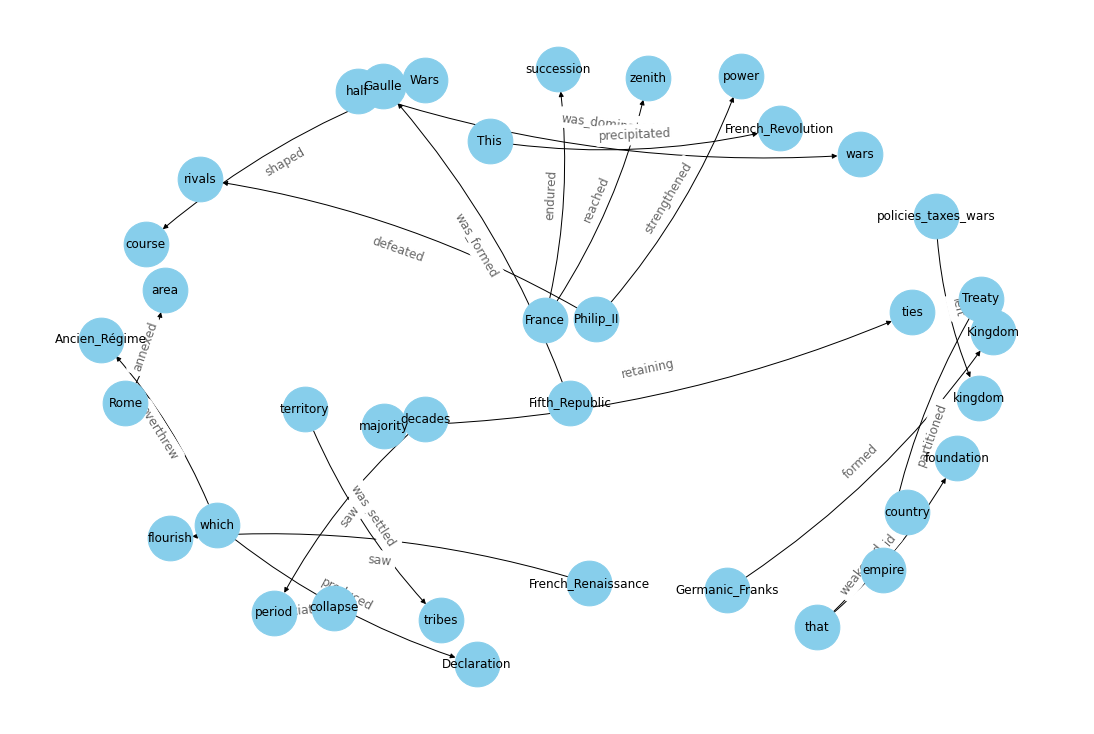

entity
which        2
that         2
Philip_II    2
France       2
territory    1
Name: count, dtype: int64


In [81]:

ent_counts, graph = doc2network(sample_doc, attributes, True, (1, 1, 1))
print(ent_counts)

In [ ]:
# graph network filtered for keyword node
#filter_network(graph, "France", attributes)

In [89]:
# 3D representations

from mpl_toolkits.mplot3d import Axes3D

def filter_network_3D(G, filter_, labels=[None]*3):
    f = filter_
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection="3d")
    pos = nx.spring_layout(G, k=2.5, dim=3)

    nodes = np.array([pos[v] for v in sorted(G) if v!=f]) 
    center_node = np.array([pos[v] for v in sorted(G) if v==f])

    edges = np.array([(pos[u],pos[v]) for u,v in G.edges() if v!=f]) 
    center_edges = np.array([(pos[u],pos[v]) for u,v in G.edges() if v==f])

    ax.scatter(*nodes.T, s=200, ec="w", c="skyblue", alpha=0.5) 
    ax.scatter(*center_node.T, s=200, c="red", alpha=0.5)

    for link in edges:
        ax.plot(*link.T, color="grey", lw=0.5)
    for link in center_edges: 
        ax.plot(*link.T, color="red", lw=0.5)
    for v in sorted(G): 
        ax.text(*pos[v].T, s=v)
    for u,v in G.edges():
        attr = nx.get_edge_attributes(G, "relation")[(u,v)] 
        ax.text(*((pos[u]+pos[v])/2).T, s=attr)

    ax.set(xlabel=labels[0], ylabel=labels[0], zlabel=labels[0], xticklabels=[], yticklabels=[], zticklabels=[])
    ax.grid(False)

    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([]) 
    plt.show()

['Latent Dim 1', 'Latent Dim 2', 'Latent Dim 3']


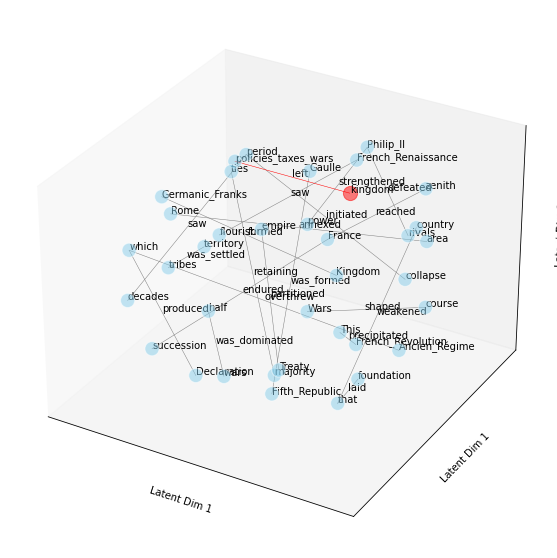

In [88]:
labels = ["Latent Dim 1", "Latent Dim 2", "Latent Dim 3"]
filter_network_3D(graph, "kingdom", labels)

In [ ]:
df = filtered
df.head()

## Network Graph Analysis

In [95]:
import networkx as nx
import community

def graph_stats(G):
    graph_stats = {}
    node_metrics = {}
    node_metrics_df = {}
    connectedness = {}
    embeddedness = {}
    
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        connectedness[node] = len(neighbors)
        embeddedness[node] = sum([len(list(G.neighbors(neighbor))) for neighbor in neighbors])
        
    # Calculate significance score for each node and node metrics
    score = {node: (connectedness[node]+1) * (embeddedness[node]+1) for node in G.nodes}

    try:
        node_metrics['Eigen-centrality'] = nx.eigenvector_centrality(G)
        node_metrics['Ave Shortest Path'] = nx.average_shortest_path_length(G)
        node_metrics['Diameter'] = nx.diameter(G)
    except:
        print("Graph is not fully connected")
        
    #node_metrics['Degree Hist'] = nx.degree_histogram(G)
    node_metrics['Betweenness Centrality'] = nx.betweenness_centrality(G)
    node_metrics['Closeness Centrality'] = nx.closeness_centrality(G)
    node_metrics['Degree Centrality'] = nx.degree_centrality(G)
    node_metrics['Clustering Coeff'] = nx.clustering(G)
    node_metrics['Connectedness'] = connectedness
    node_metrics['Embeddedness'] = embeddedness
    node_metrics['Scores'] = score # score is a superposition between embeddedness and connectedness
    
    # node_metrics is a dictionary of dictionaries
    
    for k, metric in node_metrics.items():
        for key, value in metric.items():
            if key not in node_metrics_df.keys():
                node_metrics_df[key] = []
                node_metrics_df[key].append(value)
            else:
                node_metrics_df[key].append(value)
            
    
    # Find the node with the maximum significance score
    max_node = max(score, key=score.get)
    max_score = max(score.values())
    
    connectedness = pd.DataFrame(list(connectedness.items()), columns=['Node', 'Connectedness'])
    embeddedness = pd.DataFrame(list(embeddedness.items()), columns=['Node', 'Embeddedness'])
    max_node_neighbors = list(G.neighbors(max_node))
    
    # overall graph statistics
    
    graph_stats['Nodes'] = G.number_of_nodes()
    graph_stats['Assortativity Coeff'] = nx.degree_assortativity_coefficient(G)
    graph_stats['Transitivity'] = nx.transitivity(G)
    
    # community detection within entity network (only works for FC graphs)
    '''
    # Perform Louvain community detection
    louvain_communities = community.best_partition(G)

    # Perform Girvan-Newman community detection
    girvan_newman_communities = tuple(nx.community.girvan_newman(G))

    # Print the results
    print("Louvain communities:")
    for node, community_id in louvain_communities.items():
        print(f"Node {node}: Community {community_id}")

    print("\nGirvan-Newman communities:")
    for idx, communities in enumerate(girvan_newman_communities):
        print(f"Level {idx}: {communities}")
    '''
    
    df_graph = pd.DataFrame(graph_stats, index=["Doc Graph"], columns=graph_stats.keys())
    df_nodes = pd.DataFrame(node_metrics)
    df_nodes = df_nodes.rename(columns={0: 'Entity'})

    metric = 'Closeness Centrality'
    df_nodes = df_nodes.sort_values(metric, ascending=False)
    print("Graph sorted by", metric)
    
    return df_graph, df_nodes, max_node, max_score, max_node_neighbors


In [96]:
df_graph, df_nodes, max_node, max_score, max_node_neighbors = graph_stats(graph)
display(df_graph.head())
display(df_nodes.head())
print("Most Imp Node:", max_node)
print("Node Score:", max_score)
print("Most Imp Neighbors:", max_node_neighbors)


Graph is not fully connected
Graph sorted by Closeness Centrality


,Nodes,Assortativity Coeff,Transitivity
Doc Graph,37,-0.254514,0


,Betweenness Centrality,Closeness Centrality,Degree Centrality,Clustering Coeff,Connectedness,Embeddedness,Scores
period,0.0,0.055556,0.055556,0,0,0,1
ties,0.0,0.027778,0.027778,0,0,0,1
zenith,0.0,0.027778,0.027778,0,0,0,1
Ancien_Régime,0.0,0.027778,0.027778,0,0,0,1
French_Revolution,0.0,0.027778,0.027778,0,0,0,1


Most Imp Node: that
Node Score: 3
Most Imp Neighbors: ['foundation', 'country']


## Document Timeline (beta)

In [97]:


def doc_timeline(topic, doc, start_year=None, nan_filter=True, df=None):
    '''
    topic: string for topic of document
    doc: single string document
    start_year: timeline only displays events after starting year in string format "yyyy"
    nan_filter: removes NaN entries in dataframe if True, defaults 
    df: Pass in existing filtered df dataframe for speedup
    
    Returns: dataframe with timestamped tuples
    '''
    if df is None:
        attributes, df = extract_attributes(doc, ['DATE']) #original_docs[0])
    
    df["dt"] = df["DATE"].apply(lambda x: utils_parsetime(x)) # call date REGEX helper
    #display(df)
    df[df["id"]==0]

    tmp = df.copy()
    tmp["tuples"] = tmp["entity"] + " " + tmp["relation"] + " " + tmp["object"]
    df = df.merge(tmp[["id","tuples"]], how="left", on="id") 
    
    # filter for NaN values
    if nan_filter:
        df = df[~df["tuples"].isna()].sort_values("dt",
            ascending=True).drop_duplicates("tuples", keep='first')
        df = df[~df["dt"].isna()].sort_values("dt",
            ascending=True).drop_duplicates("tuples", keep='first')

    if start_year is not None:
        dates = df[df["dt"] > start_year]["dt"].values
        names = df[df["dt"] > start_year]["tuples"].values
    else:
        dates = df["dt"].values
        names = df["tuples"].values
        
    l = [10,-10, 8,-8, 6,-6, 4,-4, 2,-2]
    levels = np.tile(l, int(np.ceil(len(dates)/len(l))))[:len(dates)]

    fig, ax = plt.subplots(figsize=(20,10)) 
    ax.set(title=topic, yticks=[], yticklabels=[])

    ax.vlines(dates, ymin=0, ymax=levels, color="tab:red")
    ax.plot(dates, np.zeros_like(dates), "-o", color="k", markerfacecolor="w")

    for d,l,r in zip(dates,levels,names):
        ax.annotate(r, xy=(d,l), xytext=(-3, np.sign(l)*3),
            textcoords="offset points", 
            horizontalalignment="center", 
            verticalalignment="bottom" if l>0 else "top")

    plt.xticks(rotation=90) 
    plt.show()
    
    return df

In [98]:
sample_1 = "Stephen William Hawking (8 January 1942 – 14 March 2018) was an English theoretical physicist, cosmologist, and author who, at the time of his death, was director of research at the Centre for Theoretical Cosmology at the University of Cambridge.[6][17][18] Between 1979 and 2009, he was the Lucasian Professor of Mathematics at the University of Cambridge, widely viewed as one of the most prestigious academic posts in the world. \
Hawking was born in Oxford into a family of physicians. In October 1959, at the age of 17, he began his university education at University College, Oxford, where he received a first-class BA degree in physics. In October 1962, he began his graduate work at Trinity Hall at the University of Cambridge where, in March 1966, he obtained his PhD degree in applied mathematics and theoretical physics, specialising in general relativity and cosmology. In 1963, at age 21, Hawking was diagnosed with an early-onset slow-progressing form of motor neurone disease that gradually, over decades, paralysed him.[20][21] After the loss of his speech, he communicated through a speech-generating device initially through use of a handheld switch, and eventually by using a single cheek muscle. \
Hawking's scientific works included a collaboration with Roger Penrose on gravitational singularity theorems in the framework of general relativity, and the theoretical prediction that black holes emit radiation, often called Hawking radiation. Initially, Hawking radiation was controversial. By the late 1970s and following the publication of further research, the discovery was widely accepted as a major breakthrough in theoretical physics. Hawking was the first to set out a theory of cosmology explained by a union of the general theory of relativity and quantum mechanics. He was a vigorous supporter of the many-worlds interpretation of quantum mechanics. \
Hawking achieved commercial success with several works of popular science in which he discussed his theories and cosmology in general. His book A Brief History of Time appeared on the Sunday Times bestseller list for a record-breaking 237 weeks. Hawking was a Fellow of the Royal Society, a lifetime member of the Pontifical Academy of Sciences, and a recipient of the Presidential Medal of Freedom, the highest civilian award in the United States. In 2002, Hawking was ranked number 25 in the BBC's poll of the 100 Greatest Britons. He died in 2018 at the age of 76, after living with motor neurone disease for more than 50 years."

sample_2 = "The French Revolution (French: Révolution française) was a period of radical political and societal change in France that began with the Estates General of 1789 and ended with the formation of the French Consulate in November 1799. Many of its ideas are considered fundamental principles of liberal democracy,[1] while the values and institutions it created remain central to French political discourse. \
Its causes are generally agreed to be a combination of social, political and economic factors, which the Ancien Régime proved unable to manage. In May 1789, widespread social distress led to the convocation of the Estates General, which was converted into a National Assembly in June. Continuing unrest culminated in the Storming of the Bastille on 14 July, which led to a series of radical measures by the Assembly, including the abolition of feudalism, the imposition of state control over the Catholic Church in France, and extension of the right to vote. \
The next three years were dominated by the struggle for political control, exacerbated by economic depression and civil disorder. Austria, Britain, Prussia and other external powers sought to restore the Ancien Régime by force, while many French politicians saw war as the best way to unite the nation and preserve the revolution by exporting it to other countries. These factors resulted in the outbreak of the French Revolutionary Wars in April 1792, abolition of the French monarchy and proclamation of the French First Republic in September 1792, followed by the execution of Louis XVI in January 1793. \
Following the Paris-based Insurrection of 31 May – 2 June 1793 the constitution was suspended and effective political power passed from the National Convention to the more radical Committee of Public Safety. An estimated 16,000 counter-revolutionaries were executed during the subsequent Reign of Terror, which ended with the so-called Thermidorian Reaction in July 1794. As well as external threats, the Republic faced internal opposition from royalists and popular unrest. In order to deal with these, a new, less democratic, constitution established a five-man Directory which took power in November 1795. Despite a series of military victories, many won by Napoleon Bonaparte, political divisions and economic stagnation resulted in the Directory being replaced by the Consulate in November 1799. This is generally seen as marking the end of the Revolutionary period."


In [99]:
test_date = "april 1988"
date = utils_parsetime(test_date)
print(date)

1988-04-03


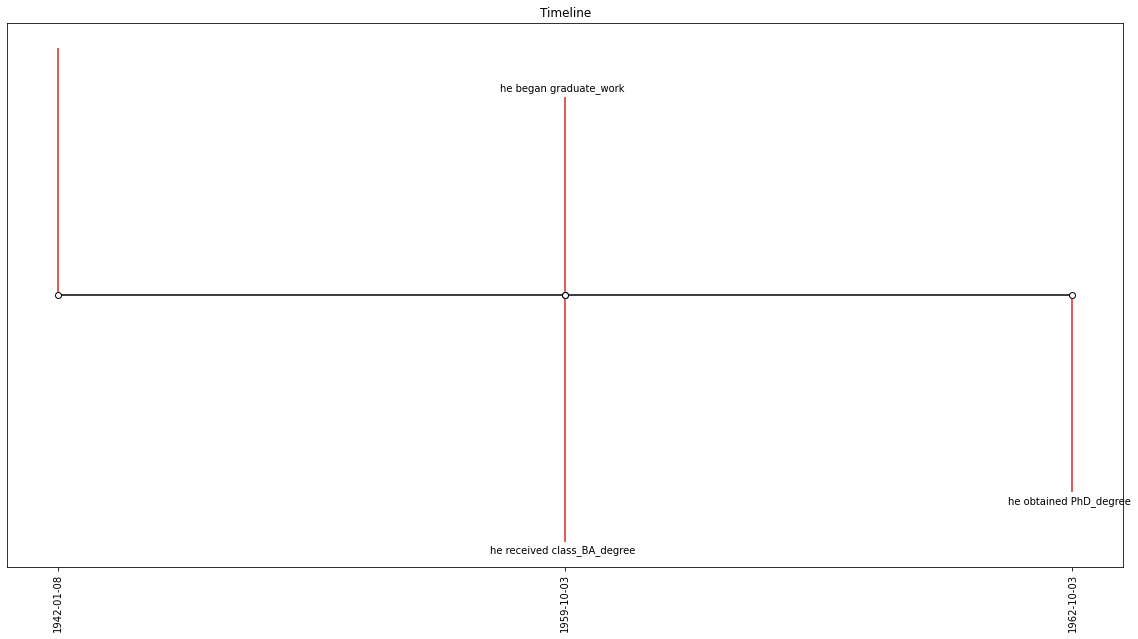

,id,text,entity,relation,object,DATE,dt,tuples
0,0,Stephen William Hawking (8 January 1942 – 14 M...,,,,8 January 1942 –,1942-01-08,
2,2,"In October 1959, at the age of 17, he began hi...",he,received,class_BA_degree,October 1959,1959-10-03,he received class_BA_degree
3,2,"In October 1959, at the age of 17, he began hi...",he,received,class_BA_degree,October 1959,1959-10-03,he began graduate_work
6,3,"In October 1962, he began his graduate work at...",he,obtained,PhD_degree,October 1962,1962-10-03,he obtained PhD_degree


In [100]:
timeline = doc_timeline("Timeline", sample_1)
display(timeline)

# Stylometric Analysis

## Document Fingerprinting and Stylometric Clustering

## Author Attribution Techniques

### Mendolssohn's Characteristic Curves of Composition

In [ ]:
# Load nltk
%matplotlib inline

'''
authors = ("A", "B", "C", "D") # enter labeled author names as tuple for supervised learning

# Transform the authors' corpora into lists of word tokens
text_by_author_tokens = {}
text_token_dist = {}

for author in authors:
    tokens = nltk.word_tokenize(text_by_author[author], language='english')

    # Filter out punctuation
    text_by_author_tokens[author] = ([token for token in tokens if any(c.isalpha() for c in token)])

    # Get a distribution of token lengths per doc
    token_lengths = [len(token) for token in text_by_author_tokens[author]]
    text_token_dist[author] = nltk.FreqDist(token_lengths)
    text_token_dist[author].plot(15,title=author)

print(token_freq[:100])
'''

def comp_curve(doc, name, normalize=True, plot=True):
    '''
    Generate a composition token frequency curve for a given document in string format
    '''
    # Transform the authors' corpora into lists of word tokens
    text_by_author_tokens = {}
    text_token_dist = {}
    
    tokens = nltk.word_tokenize(doc, language='english')
    
    # Filter out punctuation
    text_by_author_tokens = ([token for token in tokens if any(c.isalpha() for c in token)])

    # Get a distribution of token lengths per doc
    token_lengths = [len(token) for token in text_by_author_tokens]
    text_token_dist = nltk.FreqDist(token_lengths)
    total_tokens = len(text_by_author_tokens)
    
    # Normalize the token length distribution over the document length
    normalized_dist = nltk.FreqDist({length: freq / total_tokens for length, freq in text_token_dist.items()})

    if plot:
        # Plot the normalized token length distribution
        normalized_dist.plot(15, title="Doc: " + name)
    
    #text_token_dist.plot(15, title="Doc: " + name)
    return token_lengths, normalized_dist

sample_doc = 0

for i in range(3):
    comp_curve(doc_strings[i], doc_names[i])


In [ ]:
def comp_compare(doc_1, doc_2):
    '''
    Compare doc_1 to disputed doc_2
    Returns normalized similarity score between two docs based on token composition
    '''
    score = 0
    token_lengths_1, normalized_dist_1 = comp_curve(doc_1, "Doc 1", True, False)
    token_lengths_2, normalized_dist_2 = comp_curve(doc_2, "Doc 1", True, False)
        
    for i in range(min(len(normalized_dist_1), len(normalized_dist_2))):
        score += abs(normalized_dist_1[i] - normalized_dist_2[i])
        
    return score

# call comp compare function
sample_doc = 0
score = comp_compare(doc_strings[sample_doc], doc_strings[sample_doc+3])

In [ ]:
def comp_attribute(docs, disputed):
    '''
    From list of docs as doc strings, find most similar doc to disputed doc from token composition
    returns doc index in docs
    '''
    scores = []
    for doc in docs:
        score = comp_compare(doc, disputed)
        scores.append(score)
        
    return scores.index(min(scores))

similar_doc = comp_attribute(doc_strings[0:8], doc_strings[7])
similar_doc_name = doc_names[similar_doc]
print(similar_doc_name)

### Kilgariff's Chi-Squared Method

In [ ]:


# Calculate chisquared for a given document

def chi_stat(docs, disputed, name):
    '''
    docs: tokenized versions of list of documents
    disputed: tokenized document (list of words)
    name: name of disputed doc
    
    Lower chi-squared statistic is indicative of similarity between doc i and disputed doc
    '''
    chi_values = []
    
    for i, doc in enumerate(docs):

        # First, build a joint corpus and identify the 500 most frequent words in it
        joint_corpus = (doc + disputed)
        joint_freq_dist = nltk.FreqDist(joint_corpus)
        most_common = list(joint_freq_dist.most_common(500))

        # What proportion of the joint corpus is made up
        # of the candidate author's tokens?
        author_share = (len(doc) / len(joint_corpus))

        # Now, let's look at the 500 most common words in the candidate
        # author's corpus and compare the number of times they can be observed
        # to what would be expected if the author's papers
        # and the Disputed papers were both random samples from the same distribution.
        chisquared = 0
        for word, joint_count in most_common:

            # How often do we really see this common word?
            author_count = doc.count(word)
            disputed_count = disputed.count(word)

            # How often should we see it?
            expected_author_count = joint_count * author_share
            expected_disputed_count = joint_count * (1-author_share)

            # Add the word's contribution to the chi-squared statistic
            chisquared += ((author_count-expected_author_count) *
                           (author_count-expected_author_count) /
                           expected_author_count)

            chisquared += ((disputed_count-expected_disputed_count) *
                           (disputed_count-expected_disputed_count)
                           / expected_disputed_count)

        print("The Chi-squared statistic for candidate", i+1, "is", chisquared)
        chi_values.append(chisquared)
        
    idx = chi_values.index(min(chi_values))
    return min(chi_values), docs[idx]

In [ ]:


sample = 0
min_chi, doc = chi_stat([docs[sample], docs[3]], docs[sample], doc_names[sample])


In [ ]:
# Who are the authors we are analyzing?
'''

authors = ("A", "B")

# Lowercase the tokens so that the same word, capitalized or not,
# counts as one word
for author in authors:
    text_by_author_tokens[author] = ([token.lower() for token in text_by_author_tokens[author]])
    text_by_author_tokens["C"] = ([token.lower() for token in text_by_author_tokens["Disputed"]])

# Calculate chisquared for each of the two candidate authors
for author in authors:

    # First, build a joint corpus and identify the 500 most frequent words in it
    joint_corpus = (text_by_author_tokens[author] + text_by_author_tokens["Disputed"])
    joint_freq_dist = nltk.FreqDist(joint_corpus)
    most_common = list(joint_freq_dist.most_common(500))

    # What proportion of the joint corpus is made up
    # of the candidate author's tokens?
    author_share = (len(text_by_author_tokens[author]) / len(joint_corpus))

    # Now, let's look at the 500 most common words in the candidate
    # author's corpus and compare the number of times they can be observed
    # to what would be expected if the author's papers
    # and the Disputed papers were both random samples from the same distribution.
    chisquared = 0
    for word, joint_count in most_common:

        # How often do we really see this common word?
        author_count = text_by_author_tokens[author].count(word)
        disputed_count = text_by_author_tokens["Disputed"].count(word)

        # How often should we see it?
        expected_author_count = joint_count * author_share
        expected_disputed_count = joint_count * (1-author_share)

        # Add the word's contribution to the chi-squared statistic
        chisquared += ((author_count-expected_author_count) *
                       (author_count-expected_author_count) /
                       expected_author_count)

        chisquared += ((disputed_count-expected_disputed_count) *
                       (disputed_count-expected_disputed_count)
                       / expected_disputed_count)

    print("The Chi-squared statistic for candidate", author, "is", chisquared)
    
'''

### John Burrows' Delta Method

In [ ]:
import math
# Calculate chisquared for a given document

def delta_stat(authors, doc_dict, disputed, name):
    '''
    authors: name of authors or document names
    doc_dict: collection of docs emcompassing authors (tokenized list) mapping author to document
    disputed: tokenized document (list of words)
    name: name of disputed doc
    
    Returns: delta scores of each doc and most similar doc name to disputed doc
    Lower delta statistic is indicative of similarity between doc i and disputed doc
    '''
    
    if "" in authors:
        print("Disputed doc cannot be existing doc in parameter corpus")
        return
    
    # add disputed doc to joint processing
    authors.append(name)
    doc_dict[name] = disputed
    
    joint_corpus = []
    for author in authors:
        joint_corpus += doc_dict[author]
    joint_freq_dist = nltk.FreqDist(joint_corpus)
    most_common = list(joint_freq_dist.most_common(500))
        
        
    # The main data structure for feature selection
    features = [word for word,freq in most_common]
    feature_freqs = {} # 2D dictionary

    # Calculating features for each subcorpus
    for author in authors:
        feature_freqs[author] = {}
        overall = len(doc_dict[author])

        # Calculate each feature's presence in the subcorpus
        for feature in features:
            presence = doc_dict[author].count(feature)
            feature_freqs[author][feature] = presence / overall
            
    # Calculating feature averages and standard deviations
    corpus_features = {}
    for feature in features:
        # Create a sub-dictionary that will contain the feature's mean
        # and standard deviation
        corpus_features[feature] = {}

        # Calculate the mean of the frequencies expressed in the subcorpora
        feature_average = 0
        
        for author in authors:
            feature_average += feature_freqs[author][feature]
        feature_average /= len(authors)
        corpus_features[feature]["Mean"] = feature_average

        # Calculate the standard deviation using the basic formula for a sample
        feature_stdev = 0
        for author in authors:
            diff = feature_freqs[author][feature] - corpus_features[feature]["Mean"]
            feature_stdev += diff**2
        feature_stdev /= (len(authors) - 1)
        feature_stdev = math.sqrt(feature_stdev)
        corpus_features[feature]["StdDev"] = feature_stdev
    
    # calculate Z-scores
    feature_zscores = {}
    for author in authors:
        feature_zscores[author] = {}
        for feature in features:

            # Z-score definition = (value - mean) / stddev
            # We use intermediate variables to make the code easier to read
            feature_val = feature_freqs[author][feature]
            feature_mean = corpus_features[feature]["Mean"]
            feature_stdev = corpus_features[feature]["StdDev"]
            feature_zscores[author][feature] = ((feature_val-feature_mean) / feature_stdev)
      
    # ========================= Treatment of Test Case ===========================
    
    # Calculate the test case's features
    overall = len(disputed)
    testcase_freqs = {}
    for feature in features:
        presence = disputed.count(feature)
        testcase_freqs[feature] = presence / overall

    # Calculate the test case's feature z-scores
    testcase_zscores = {}
    for feature in features:
        feature_val = testcase_freqs[feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
        #print("Test case z-score for feature", feature, "is", testcase_zscores[feature])
    
    # ========================== Calculate Delta Scores =======================
    deltas = []
    for author in authors:
        delta = 0
        for feature in features:
            delta += math.fabs((testcase_zscores[feature] - feature_zscores[author][feature]))
        delta /= len(features)
        deltas.append(delta)
        #print("Delta score for candidate", author, "is", delta )
    
    diffs = []
    for i in range(len(authors)):
        diffs.append(abs(deltas[-1] - deltas[i]))
        
    if min(diffs) == 0:
        idx = second_small_index(diffs) # call helper
    else:
        idx = diffs.index(min(diffs))
        
    similar_doc = authors[idx]
    return deltas, similar_doc

In [ ]:
authors = doc_names[0:8]
doc_slice = dict(islice(doc_dict.items(), 8))
disputed = 9
print("Disputed doc: ", doc_names[disputed])
deltas, similar_doc = delta_stat(authors, doc_slice, docs[disputed], doc_names[disputed])

# If delta is 0, then the disputed author and/or corpus consists of only a single document written by that author/with that document title

print(f"Disputed doc {doc_names[disputed]} is most similar to: {similar_doc}")

## Plagarism Detection

## Named Entity Recognition (see Knowledge Graphs)

In [ ]:
from nltk import ne_chunk
import spacy 
nlp = spacy.load('en_core_web_sm')

# Creating a spacy doc of a sentence
sentence=' The building is located at London. It is the headquaters of Yahoo. John works there. He speaks English'
doc=nlp(sentence)

# **Trainable Custom ChatBots (Colab)**

In [ ]:
'''
from simpletransformers.conv_ai import ConvAIModel
import torch

train_args = {
    "fp16": False,
    "num_train_epochs": 1,
    "save_model_every_epoch": False
}

# Provide training data or path to training data
train_data = [
    ["Hello!", "Hi there!"],
    ["How are you?", "I'm doing well, thanks!"],
    # Add more conversation pairs
]

my_chatbot = ConvAIModel("gpt", "openai-gpt", use_cuda=True, args=train_args)
my_chatbot.train_model(train_data)  # Provide the training data here
my_chatbot.interact()
'''

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments

# Step 1: Prepare Data
# Provide training data or path to training data
train_data = [
    ["Hello!", "Hi there!"],
    ["How are you?", "I'm doing well, thanks!"],
    # Add more conversation pairs
]

# Step 2: Tokenization
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")  # Use GPT-2 tokenizer
tokenized_data = tokenizer(train_data, padding=True, truncation=True, return_tensors="pt") #pad_token_id=tokenizer.eos_token_id)
tokenizer.pad_token = tokenizer.eos_token
print("Token", tokenizer.pad_token)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, pad_to_multiple_of=None)  # No need to specify pad_token

# Step 3: Model Selection and Fine-tuning
model = GPT2LMHeadModel.from_pretrained("gpt2")  # Use GPT-2 pre-trained model

# Fine-tuning parameters
training_args = TrainingArguments(
    output_dir="./chatbot_model",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=500,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data,
    data_collator=data_collator,  # Use the custom data collator
)

trainer.train()

# Step 6: Evaluation (Optional)
# If you have a validation set or test set, evaluate the chatbot's performance

# Step 7: Chatbot Inference
# Load the trained model and use it for chatbot inference

# For example:
chatbot_model = GPT2LMHeadModel.from_pretrained("./chatbot_model")
chatbot_input = "Hello, how are you?"
chatbot_input_ids = tokenizer.encode(chatbot_input, return_tensors="pt")
chatbot_output = chatbot_model.generate(chatbot_input_ids, max_length=50, num_return_sequences=5, pad_token_id=tokenizer.eos_token_id)

for output_id in chatbot_output:
    output_text = tokenizer.decode(output_id, skip_special_tokens=True)
    print(output_text)


# **Document Classification Given Labels**

In [ ]:
# Use Doc2Vec strategy

import gensim
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Load the training data
train_data = [
    TaggedDocument(words=preprocess_text(doc['text']), tags=[doc['label']])
    for doc in train_docs
]

# Train the Doc2Vec model on the training data
model = Doc2Vec(vector_size=100, window=5, min_count=5, epochs=20)
model.build_vocab(train_data)
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

# Classify the test data
for doc in test_docs:
    # Preprocess the text
    tokens = preprocess_text(doc['text'])
    # Infer the vector for the preprocessed text
    inferred_vector = model.infer_vector(tokens)
    # Use the model to predict the label for the document
    predicted_label = model.docvecs.most_similar([inferred_vector])[0][0]
    # Print the predicted label for the document
    print("Predicted label for document:", predicted_label)


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Sample data
data = [
    ("I love this movie", "positive"),
    ("This was an awesome experience", "positive"),
    ("I hated this movie", "negative"),
    ("I didn't enjoy the show", "negative"),
]

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create tagged documents
tagged_train_data = [TaggedDocument(words=text.split(), tags=[label]) for text, label in train_data]

# Initialize Doc2Vec model
model = Doc2Vec(vector_size=100, window=5, min_count=1, epochs=10)

# Build vocabulary
model.build_vocab(tagged_train_data)

# Train the Doc2Vec model
model.train(tagged_train_data, total_examples=model.corpus_count, epochs=model.epochs)

# Prepare training data
train_vectors = [model.infer_vector(tagged_doc.words) for tagged_doc in tagged_train_data]
train_labels = [tagged_doc.tags[0] for tagged_doc in tagged_train_data]

# Train a classifier
classifier = LogisticRegression()
classifier.fit(train_vectors, train_labels)

# Evaluate on test data
tagged_test_data = [TaggedDocument(words=text.split(), tags=[label]) for text, label in test_data]
test_vectors = [model.infer_vector(tagged_doc.words) for tagged_doc in tagged_test_data]
test_labels = [tagged_doc.tags[0] for tagged_doc in tagged_test_data]

accuracy = classifier.score(test_vectors, test_labels)
print("Accuracy:", accuracy)


# Save and Load Project States

In [ ]:
# Save all variables and data structures to a file
with open("./variables.pkl", "wb") as file:
    vars = (
            docs,
            doc_strings,
            doc_names,
            doc_dict,
            doc_sents,
            dictionary,
            topics,
            topic_ratios,
            all_topics,
            freq_chart,
            corpus,
            df_count,
            df_tdidf,
            summaries,
            word_freq_docs,
            word_freq_corpus,
            coherence_values,
            original_docs
            model
            )
    pickle.dump(vars, file)
print("Save Complete")

In [ ]:
import pickle
# Load all variables from file
with open("./variables.pkl", "rb") as file:
    (
        docs,
        doc_strings,
        doc_names,
        doc_dict,
        doc_sents,
        dictionary,
        topics,
        topic_ratios,
        all_topics,
        freq_chart,
        corpus,
        df_count,
        df_tdidf,
        summaries,
        word_freq_docs,
        word_freq_corpus,
        coherence_values,
        original_docs,
        #model
    ) = pickle.load(file)
print("Load Complete")

# PCA Visualizations and Clustering Algorithms (Google Colab)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

user1_vectors = np.load('./datasets/youtube_features.npy')
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(user1_vectors)

pca = PCA(n_components=3)
projected_vectors = pca.fit_transform(user1_vectors)

metadata_file = 'metadata.tsv'
with open(metadata_file, 'w') as f:
    for label in cluster_labels:
        f.write(str(label) + '\n')


In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector
embedding_var = tf.Variable(projected_vectors, name='user1_embeddings')
summary_writer = tf.summary.FileWriter('logs')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = metadata_file

projector.visualize_embeddings(summary_writer, config)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, 'logs/model.ckpt')


In [ ]:
!tensorboard --logdir=logs

# **Experimental**

### **Tokenization**

In [ ]:
# Tokenization
'''
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

#data_words = list(sent_to_words(data))
doc_words = list(sent_to_words(docs)) # returns list of [list of words]
max_words = 50

#print(data_words[:1])
print(doc_words[0][:max_words]) # prints first max_words in first doc

# 2D List Sentence Datatype:
# list of sentences, where each list element contains word elements

'''
# =============================
'''
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
'''

In [ ]:
# Use a Unigram Model
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Install LLMs
'''
!python -m spacy download fr_core_news_sm # French
!python -m spacy download en_core_web_sm # English
'''
'''
DOESN'T WORK
'''
!pip install fr-core-news-sm
!pip install en_core_web_sm


### **Lemmatization**

In [ ]:
# Continue preprocess data: remove STOP WORDS
# Make N-grams

# Remove Stop Words
stop_words = ['.', ',']
data_words_nostops = remove_stopwords(data_words, stop_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('fr_core_news_sm')
# for French LLM: fr_core_news_sm
# for French LLM: en_core_web_sm

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

### Word to Vector

In [ ]:
# import data
sentences = list(sent_to_words(data))

# train the model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# print the learned vocabulary
vocab = model.wv.index_to_key
word_vectors = [model.wv.get_vector(word) for word in vocab]

print(random.sample(vocab, k=10))

sample_word = 'try'
sample_vect = model.wv[sample_word] if sample_word in vocab else None

# get the vector representation of a word
print(sample_vect)

## Spacy 

In [ ]:
import spacy
from spacy.lang.en.examples import sentences 

nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("fr_core_news_sm")

doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)


# Memory Utilization

In [ ]:
from resource import getrusage, RUSAGE_SELF
print("Peak memory (MB):", int(getrusage(RUSAGE_SELF).ru_maxrss/1024000))